# Codeword Length = 15, T = 5, p(BSC parameter) {0.01, 0.05, 0.1, 0.2}

In [1]:

# ---- Imports
import os, json, copy, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

In [2]:
print(os.listdir("/kaggle/input/bsc-0-01-15-seq-len"))

['bsc_p0.15_C1_n15_k11.csv', 'bsc_p0.40_codewords1.csv', 'bsc_p0.005_C2_n15_k7.csv', 'bsc_p0.08_C1_n15_k11.csv', 'bsc_p0.20_codewords2.csv', 'bsc_p0.01_codewords1.csv', 'bsc_p0.05_codewords1.csv', 'bsc_p0.01_codewords2.csv', 'bsc_p0.005_C1_n15_k11.csv', 'bsc_p0.001_C2_n15_k7.csv', 'bsc_p0.001_C1_n15_k11.csv', 'bsc_p0.30_codewords1.csv', 'bsc_p0.10_codewords1.csv', 'bsc_p0.20_codewords1.csv', 'bsc_p0.15_C2_n15_k7.csv', 'bsc_p0.10_codewords2.csv', 'bsc_p0.30_codewords2.csv', 'bsc_p0.40_codewords2.csv', 'bsc_p0.05_codewords2.csv', 'bsc_p0.08_C2_n15_k7.csv']


Step-by-Step Summary: Changepoint Detection Pipeline
1. Configuration Setup
Sets training parameters: sequence length T, number of classes T+1, batch size, learning rate, etc.
Specifies number of samples per class for training, validation, and testing.

2. Seeding
Fixes random seeds for reproducibility using torch, numpy, and random.

3. Load Raw Codeword Data
Reads two .csv files: one for codewords from Code1, another for Code2.
Each row represents a codeword vector of fixed length.

4. Dataset Generation
Uses generate_data_cpd() to synthesize labeled examples:
Class 0: all codewords from Code1
Class T: all codewords from Code2
Classes 1–(T−1): changepoint at position τ, mixing Code1 and Code2

Creates separate datasets:
Train: SAMPLES_PER_CLASS_TRAIN × (T+1)
Validation and Test: SAMPLES_PER_CLASS_TEST × (T+1) each

5. Label Distribution Plot
Visualizes training class distribution to confirm balanced dataset.

6. Dataset Wrapping & Loading
Wraps data in a ChangepointDataset class using PyTorch Dataset.
Loads data into DataLoader for efficient batching.

7. Model Definition
Defines a CNN-based model:
MultiscaleFeatureExtractor: 1D convs with different kernel sizes
ResidualBlock1D: ResNet-style skip connections
Classifier: global average pooling → linear classifier
Model predicts one of T+1 classes for each segment.

8. Training Loop
Trains using CrossEntropyLoss and Adam optimizer.
Monitors validation accuracy, uses:
ReduceLROnPlateau scheduler
Early stopping after PATIENCE epochs without improvement
Keeps best model checkpoint based on validation accuracy.

9. Evaluation
Loads best model.
Evaluates on test set and prints strict classification accuracy.

10. Relaxed Accuracy
Computes relaxed accuracy: prediction is correct if within ±window of true class.

Plots relaxed accuracy vs. window size.

11. Final Visualization : 
Loss and accuracy curves during training
Relaxed accuracy plot
Confusion matrix heatmap of test predictions
This pipeline trains a robust sequence classifier to detect changepoints between two codeword sources.



### How this will be used in the pipeline

### **Changepoint Detection Summary**

- **Model Input**: Sliding window of size `T`
- **Model Output**: Class label `τ̂ ∈ [0, T]`
  - `τ̂ = 0`: all from Code1
  - `τ̂ = T`: all from Code2
  - `τ̂ ∈ [1, T−1]`: changepoint at index `τ̂` in window

---

### **Changepoint Index Formula**


- `i`: start index of the window  
- `τ̂`: predicted class by the model  

This gives the **index of the first Code2 element**.

---

### **Example**

- Let `T = 5`, window starts at `i = 8`, and prediction = `τ̂ = 2`  
→ **Changepoint = 8 + 2 = 10**


### Goal: Detect the Changepoint in a Long Sequence Using a Trained Model

---

### What This Code Will Do (Step-by-Step)

1. **Input** a long sequence of codewords (from `Code1` followed by `Code2`, with a single changepoint).
2. **Slide a window** of size `T` over the sequence (stride = 1).
3. **Use your trained model** to classify each window into one of `T + 1` classes:
   - `0`: all codewords from Code1
   - `T`: all codewords from Code2
   - `1 ≤ τ̂ ≤ T-1`: changepoint is at position `τ̂` within the window
4. **Estimate the changepoint position** using:


- `i` is the start index of the window
- `τ̂` is the predicted class
5. **Return the first detected changepoint**, or continue through the sequence to refine it.

---

### Key Notes

- Uses your **already trained model** — no retraining required.
- Works on any **long sequence** with a single changepoint.
- Common and effective approach for inference with sequence classifiers.

---

### Code: Sliding Window Changepoint Detection

```python
def detect_changepoint_in_sequence(long_sequence, model, T, device):
 model.eval()
 preds = []
 changepoint_idx = None

 for i in range(len(long_sequence) - T + 1):
     window = long_sequence[i:i + T]  # (T, feature_size)
     input_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)

     with torch.no_grad():
         output = model(input_tensor)
         pred_class = output.argmax(dim=1).item()
         preds.append(pred_class)

     if 1 <= pred_class <= T - 1 and changepoint_idx is None:
         changepoint_idx = i + pred_class

 return changepoint_idx, preds


changepoint, pred_labels = detect_changepoint_in_sequence(long_sequence, model, T, device)
print("Detected changepoint index:", changepoint)


## p = 0.01

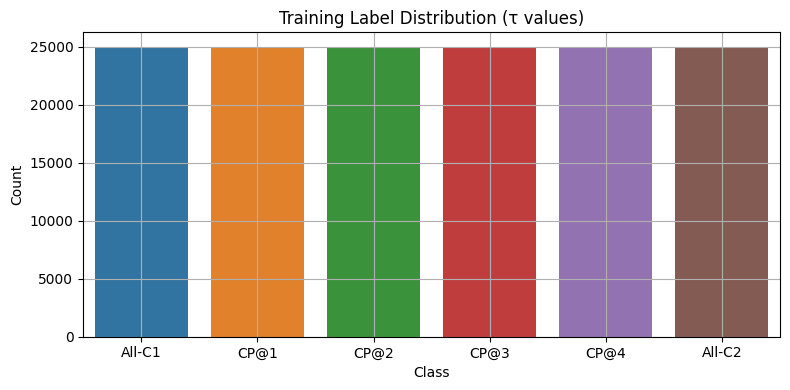

Training Epochs:   2%|▏         | 1/50 [00:14<11:28, 14.06s/it]

Epoch  1 | Train Loss: 1.7948 | Val Accuracy: 0.1831


Training Epochs:   4%|▍         | 2/50 [00:27<10:43, 13.40s/it]

Epoch  2 | Train Loss: 1.7087 | Val Accuracy: 0.4246


Training Epochs:   6%|▌         | 3/50 [00:40<10:22, 13.23s/it]

Epoch  3 | Train Loss: 1.1694 | Val Accuracy: 0.6445


Training Epochs:   8%|▊         | 4/50 [00:52<10:03, 13.12s/it]

Epoch  4 | Train Loss: 0.9298 | Val Accuracy: 0.7373


Training Epochs:  10%|█         | 5/50 [01:05<09:48, 13.07s/it]

Epoch  5 | Train Loss: 0.7709 | Val Accuracy: 0.7933


Training Epochs:  12%|█▏        | 6/50 [01:18<09:32, 13.02s/it]

Epoch  6 | Train Loss: 0.6453 | Val Accuracy: 0.8346


Training Epochs:  14%|█▍        | 7/50 [01:31<09:18, 12.98s/it]

Epoch  7 | Train Loss: 0.5398 | Val Accuracy: 0.8673


Training Epochs:  16%|█▌        | 8/50 [01:44<09:05, 12.98s/it]

Epoch  8 | Train Loss: 0.4555 | Val Accuracy: 0.8933


Training Epochs:  18%|█▊        | 9/50 [01:57<08:51, 12.97s/it]

Epoch  9 | Train Loss: 0.3880 | Val Accuracy: 0.9114


Training Epochs:  20%|██        | 10/50 [02:10<08:39, 12.99s/it]

Epoch 10 | Train Loss: 0.3350 | Val Accuracy: 0.9295


Training Epochs:  22%|██▏       | 11/50 [02:23<08:25, 12.97s/it]

Epoch 11 | Train Loss: 0.2950 | Val Accuracy: 0.9389


Training Epochs:  24%|██▍       | 12/50 [02:36<08:12, 12.97s/it]

Epoch 12 | Train Loss: 0.2619 | Val Accuracy: 0.9483


Training Epochs:  26%|██▌       | 13/50 [02:49<07:59, 12.96s/it]

Epoch 13 | Train Loss: 0.2373 | Val Accuracy: 0.9537


Training Epochs:  28%|██▊       | 14/50 [03:02<07:46, 12.95s/it]

Epoch 14 | Train Loss: 0.2189 | Val Accuracy: 0.9578


Training Epochs:  30%|███       | 15/50 [03:15<07:34, 12.99s/it]

Epoch 15 | Train Loss: 0.2033 | Val Accuracy: 0.9617


Training Epochs:  32%|███▏      | 16/50 [03:28<07:21, 12.97s/it]

Epoch 16 | Train Loss: 0.1891 | Val Accuracy: 0.9625


Training Epochs:  34%|███▍      | 17/50 [03:41<07:08, 12.98s/it]

Epoch 17 | Train Loss: 0.1791 | Val Accuracy: 0.9655


Training Epochs:  36%|███▌      | 18/50 [03:54<06:54, 12.95s/it]

Epoch 18 | Train Loss: 0.1706 | Val Accuracy: 0.9667


Training Epochs:  38%|███▊      | 19/50 [04:07<06:42, 12.98s/it]

Epoch 19 | Train Loss: 0.1617 | Val Accuracy: 0.9669


Training Epochs:  40%|████      | 20/50 [04:20<06:27, 12.93s/it]

Epoch 20 | Train Loss: 0.1563 | Val Accuracy: 0.9702


Training Epochs:  42%|████▏     | 21/50 [04:33<06:15, 12.96s/it]

Epoch 21 | Train Loss: 0.1491 | Val Accuracy: 0.9702


Training Epochs:  44%|████▍     | 22/50 [04:46<06:02, 12.94s/it]

Epoch 22 | Train Loss: 0.1477 | Val Accuracy: 0.9697


Training Epochs:  46%|████▌     | 23/50 [04:59<05:49, 12.93s/it]

Epoch 23 | Train Loss: 0.1427 | Val Accuracy: 0.9703


Training Epochs:  46%|████▌     | 23/50 [05:12<06:06, 13.57s/it]

Epoch 24 | Train Loss: 0.1365 | Val Accuracy: 0.9713
Early stopping triggered.



Final Test Accuracy: 0.9675



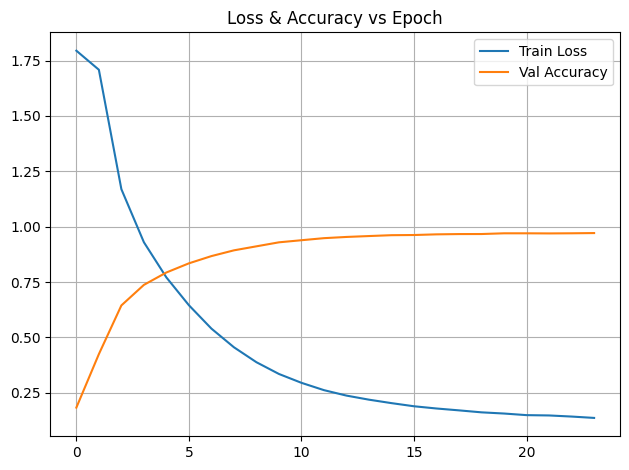

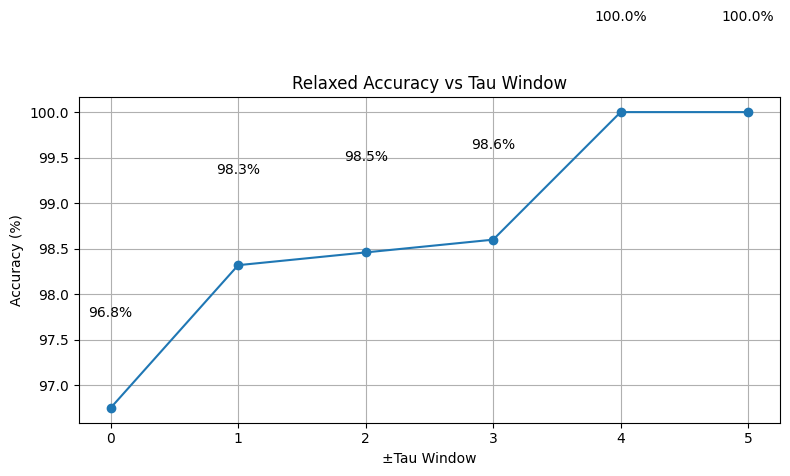

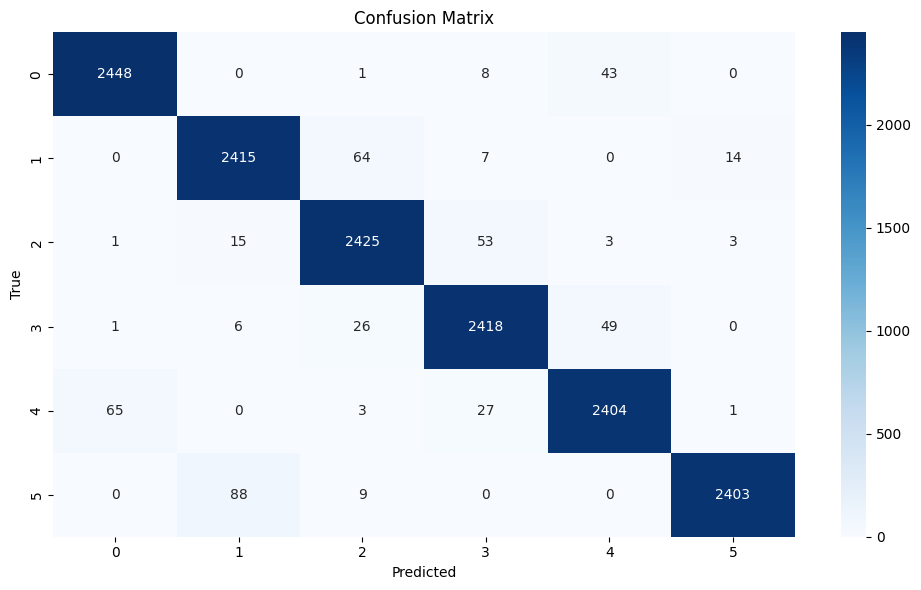


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.01_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.01_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.01_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.01_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.01_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [3]:
# ========================= Full, Download-Ready Trainer =========================
# Adds: saving state/full/TorchScript/meta to /kaggle/working + a ZIP bundle
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 25000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # init robustly
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create an informative filename prefix (includes dataset tag)
ds_tag = f"{os.path.splitext(os.path.basename(csv1_path))[0]}"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Save state_dict (recommended portable format)
torch.save(best_model_state, STATE_PATH)

# 2) Save full pickled model (convenient but environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Save metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything into a ZIP to download in one click
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================



***T = 5, p = 0.01, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 15.5, 42.2, 64.2, 83.0, 96.5, 100.0
For N'(training samples/class) = 2000     Accuracy = 18.3, 45.3, 66.0, 82.2, 94.2, 100.0
For N'(training samples/class) = 3000     Accuracy = 17.4, 46.0, 69.2, 84.9, 95.2, 100.0
For N'(training samples/class) = 4000     Accuracy = 83.5, 91.8, 92.7, 93.5, 100.0, 100.0
For N'(training samples/class) = 5000     Accuracy = 87.3, 94.1, 94.5, 95.1, 100.0, 100.0
For N'(training samples/class) = 6000     Accuracy = 89.3, 94.4, 95.0, 95.7, 100.0, 100.0
For N'(training samples/class) = 8000     Accuracy = 94.4, 97.0, 97.3, 97.6, 100.0, 100.0
For N'(training samples/class) = 10000     Accuracy = 95.2, 97.3, 97.7, 98.0, 100.0, 100.0
For N'(training samples/class) = 11000     Accuracy = 96.0, 97.9, 98.1, 98.3, 100.0, 100.0
For N'(training samples/class) = 15000     Accuracy = 96.4, 98.1, 98.4, 98.6, 100.0, 100.0
For N'(training samples/class) = 17000     Accuracy = 96.1, 98.0, 98.2, 98.4, 100.0, 100.0
For N'(training samples/class) = 20000     Accuracy = 96.9, 98.4, 98.6, 98.8, 100.0, 100
</pre>

In [ ]:
print("Predicted labels (test set):", all_preds.tolist())


## p = 0.05

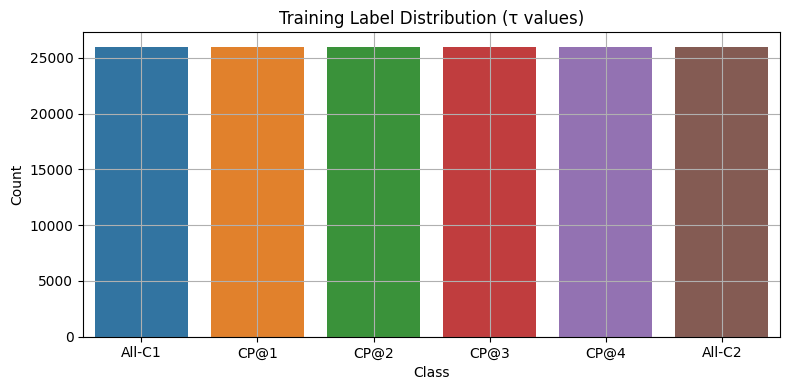

Training Epochs:   2%|▏         | 1/50 [00:13<10:58, 13.44s/it]

Epoch  1 | Train Loss: 1.7954 | Val Accuracy: 0.1756


Training Epochs:   4%|▍         | 2/50 [00:26<10:45, 13.45s/it]

Epoch  2 | Train Loss: 1.7910 | Val Accuracy: 0.1890


Training Epochs:   6%|▌         | 3/50 [00:40<10:31, 13.43s/it]

Epoch  3 | Train Loss: 1.6960 | Val Accuracy: 0.3760


Training Epochs:   8%|▊         | 4/50 [00:53<10:19, 13.47s/it]

Epoch  4 | Train Loss: 1.3666 | Val Accuracy: 0.5125


Training Epochs:  10%|█         | 5/50 [01:07<10:06, 13.48s/it]

Epoch  5 | Train Loss: 1.2074 | Val Accuracy: 0.5726


Training Epochs:  12%|█▏        | 6/50 [01:20<09:52, 13.47s/it]

Epoch  6 | Train Loss: 1.1094 | Val Accuracy: 0.6272


Training Epochs:  14%|█▍        | 7/50 [01:34<09:40, 13.50s/it]

Epoch  7 | Train Loss: 1.0239 | Val Accuracy: 0.6777


Training Epochs:  16%|█▌        | 8/50 [01:47<09:26, 13.50s/it]

Epoch  8 | Train Loss: 0.9467 | Val Accuracy: 0.7096


Training Epochs:  18%|█▊        | 9/50 [02:01<09:14, 13.52s/it]

Epoch  9 | Train Loss: 0.8873 | Val Accuracy: 0.7350


Training Epochs:  20%|██        | 10/50 [02:14<09:00, 13.50s/it]

Epoch 10 | Train Loss: 0.8381 | Val Accuracy: 0.7481


Training Epochs:  22%|██▏       | 11/50 [02:28<08:45, 13.48s/it]

Epoch 11 | Train Loss: 0.7995 | Val Accuracy: 0.7602


Training Epochs:  24%|██▍       | 12/50 [02:41<08:32, 13.48s/it]

Epoch 12 | Train Loss: 0.7683 | Val Accuracy: 0.7662


Training Epochs:  26%|██▌       | 13/50 [02:55<08:20, 13.53s/it]

Epoch 13 | Train Loss: 0.7442 | Val Accuracy: 0.7692


Training Epochs:  28%|██▊       | 14/50 [03:08<08:06, 13.50s/it]

Epoch 14 | Train Loss: 0.7244 | Val Accuracy: 0.7754


Training Epochs:  30%|███       | 15/50 [03:22<07:51, 13.49s/it]

Epoch 15 | Train Loss: 0.7041 | Val Accuracy: 0.7783


Training Epochs:  32%|███▏      | 16/50 [03:35<07:37, 13.47s/it]

Epoch 16 | Train Loss: 0.6873 | Val Accuracy: 0.7841


Training Epochs:  34%|███▍      | 17/50 [03:49<07:24, 13.47s/it]

Epoch 17 | Train Loss: 0.6706 | Val Accuracy: 0.7904


Training Epochs:  36%|███▌      | 18/50 [04:02<07:11, 13.50s/it]

Epoch 18 | Train Loss: 0.6565 | Val Accuracy: 0.7926


Training Epochs:  38%|███▊      | 19/50 [04:16<06:58, 13.49s/it]

Epoch 19 | Train Loss: 0.6432 | Val Accuracy: 0.7980


Training Epochs:  40%|████      | 20/50 [04:29<06:45, 13.51s/it]

Epoch 20 | Train Loss: 0.6311 | Val Accuracy: 0.8004


Training Epochs:  42%|████▏     | 21/50 [04:43<06:31, 13.51s/it]

Epoch 21 | Train Loss: 0.6164 | Val Accuracy: 0.8041


Training Epochs:  44%|████▍     | 22/50 [04:56<06:18, 13.50s/it]

Epoch 22 | Train Loss: 0.6012 | Val Accuracy: 0.8061


Training Epochs:  46%|████▌     | 23/50 [05:10<06:04, 13.49s/it]

Epoch 23 | Train Loss: 0.5842 | Val Accuracy: 0.8133


Training Epochs:  48%|████▊     | 24/50 [05:23<05:51, 13.50s/it]

Epoch 24 | Train Loss: 0.5738 | Val Accuracy: 0.8173


Training Epochs:  50%|█████     | 25/50 [05:37<05:37, 13.49s/it]

Epoch 25 | Train Loss: 0.5565 | Val Accuracy: 0.8192


Training Epochs:  52%|█████▏    | 26/50 [05:50<05:24, 13.52s/it]

Epoch 26 | Train Loss: 0.5438 | Val Accuracy: 0.8245


Training Epochs:  54%|█████▍    | 27/50 [06:04<05:11, 13.54s/it]

Epoch 27 | Train Loss: 0.5325 | Val Accuracy: 0.8244


Training Epochs:  56%|█████▌    | 28/50 [06:17<04:58, 13.55s/it]

Epoch 28 | Train Loss: 0.5233 | Val Accuracy: 0.8302


Training Epochs:  58%|█████▊    | 29/50 [06:31<04:45, 13.60s/it]

Epoch 29 | Train Loss: 0.5144 | Val Accuracy: 0.8343


Training Epochs:  60%|██████    | 30/50 [06:45<04:32, 13.61s/it]

Epoch 30 | Train Loss: 0.5063 | Val Accuracy: 0.8343


Training Epochs:  62%|██████▏   | 31/50 [06:58<04:18, 13.59s/it]

Epoch 31 | Train Loss: 0.4977 | Val Accuracy: 0.8370


Training Epochs:  64%|██████▍   | 32/50 [07:12<04:04, 13.59s/it]

Epoch 32 | Train Loss: 0.4927 | Val Accuracy: 0.8356


Training Epochs:  66%|██████▌   | 33/50 [07:26<03:50, 13.58s/it]

Epoch 33 | Train Loss: 0.4844 | Val Accuracy: 0.8362


Training Epochs:  68%|██████▊   | 34/50 [07:39<03:36, 13.55s/it]

Epoch 34 | Train Loss: 0.4784 | Val Accuracy: 0.8384


Training Epochs:  70%|███████   | 35/50 [07:53<03:23, 13.55s/it]

Epoch 35 | Train Loss: 0.4731 | Val Accuracy: 0.8408


Training Epochs:  72%|███████▏  | 36/50 [08:06<03:09, 13.56s/it]

Epoch 36 | Train Loss: 0.4643 | Val Accuracy: 0.8422


Training Epochs:  74%|███████▍  | 37/50 [08:20<02:55, 13.53s/it]

Epoch 37 | Train Loss: 0.4602 | Val Accuracy: 0.8440


Training Epochs:  76%|███████▌  | 38/50 [08:33<02:42, 13.54s/it]

Epoch 38 | Train Loss: 0.4551 | Val Accuracy: 0.8440


Training Epochs:  78%|███████▊  | 39/50 [08:47<02:28, 13.53s/it]

Epoch 39 | Train Loss: 0.4470 | Val Accuracy: 0.8492


Training Epochs:  80%|████████  | 40/50 [09:00<02:15, 13.53s/it]

Epoch 40 | Train Loss: 0.4451 | Val Accuracy: 0.8470


Training Epochs:  82%|████████▏ | 41/50 [09:14<02:01, 13.50s/it]

Epoch 41 | Train Loss: 0.4380 | Val Accuracy: 0.8476


Training Epochs:  84%|████████▍ | 42/50 [09:27<01:47, 13.47s/it]

Epoch 42 | Train Loss: 0.4365 | Val Accuracy: 0.8490


Training Epochs:  86%|████████▌ | 43/50 [09:41<01:34, 13.48s/it]

Epoch 43 | Train Loss: 0.4275 | Val Accuracy: 0.8513


Training Epochs:  88%|████████▊ | 44/50 [09:54<01:20, 13.50s/it]

Epoch 44 | Train Loss: 0.4243 | Val Accuracy: 0.8528


Training Epochs:  90%|█████████ | 45/50 [10:08<01:07, 13.50s/it]

Epoch 45 | Train Loss: 0.4182 | Val Accuracy: 0.8515


Training Epochs:  92%|█████████▏| 46/50 [10:21<00:54, 13.52s/it]

Epoch 46 | Train Loss: 0.4195 | Val Accuracy: 0.8522


Training Epochs:  94%|█████████▍| 47/50 [10:35<00:40, 13.53s/it]

Epoch 47 | Train Loss: 0.4139 | Val Accuracy: 0.8544


Training Epochs:  96%|█████████▌| 48/50 [10:48<00:27, 13.53s/it]

Epoch 48 | Train Loss: 0.4087 | Val Accuracy: 0.8525


Training Epochs:  98%|█████████▊| 49/50 [11:02<00:13, 13.53s/it]

Epoch 49 | Train Loss: 0.4064 | Val Accuracy: 0.8567


Training Epochs: 100%|██████████| 50/50 [11:15<00:00, 13.52s/it]

Epoch 50 | Train Loss: 0.4010 | Val Accuracy: 0.8565



Final Test Accuracy: 0.8460



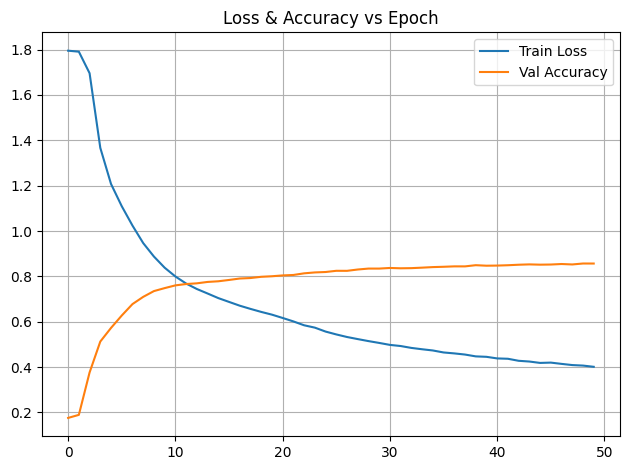

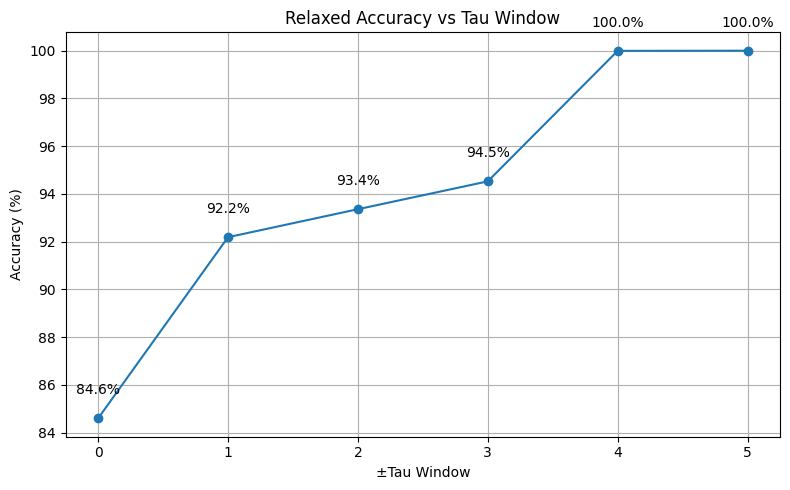

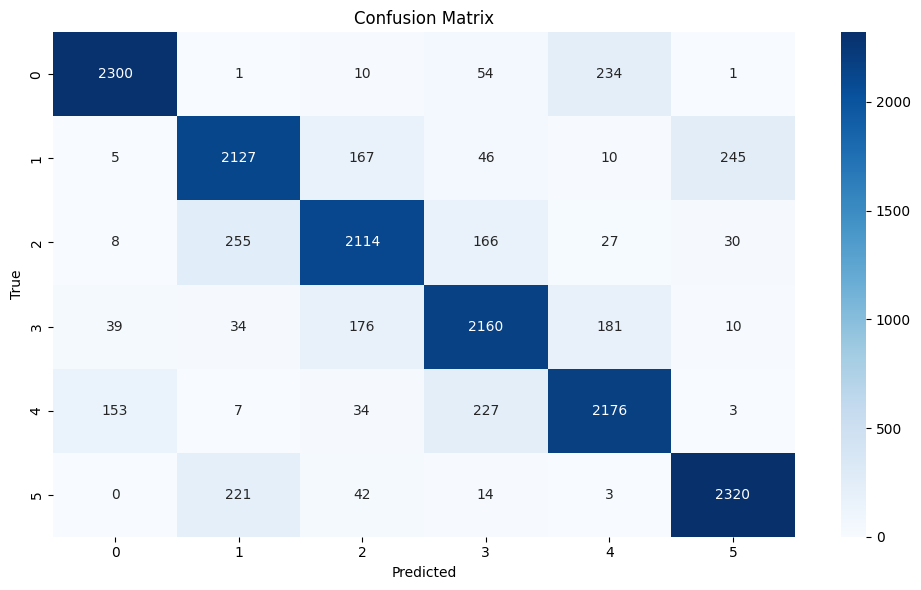


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.05_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.05_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.05_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.05_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.05_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [4]:
# ========================= Full, Download-Ready Trainer (p=0.05) =========================
# Saves state_dict, full model, TorchScript, metadata, and a ZIP bundle to /kaggle/working
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 35000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # robust init
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Include dataset tag in filenames so runs don't overwrite each other.
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]   # e.g., "bsc_p0.05_codewords1"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) full pickled model (environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) bundle to ZIP (one-click download from Output panel)
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================


***T = 5, p = 0.05, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 13.3, 38.5, 59.7, 80.5, 93.5, 100.0
For N'(training samples/class) = 2000     Accuracy = 16.0, 44.9, 66.8, 83.8, 94.0, 100.0
For N'(training samples/class) = 3000     Accuracy = 16.6, 44.2, 64.9, 82.1, 93.7, 100.0
For N'(training samples/class) = 4000     Accuracy = 17.5, 46.3, 66.1, 82.1, 95.4, 100.0
For N'(training samples/class) = 5000     Accuracy = 64.0, 80.0, 83.5, 86.5, 99.9, 100.0
For N'(training samples/class) = 6000     Accuracy = 71.3, 84.1, 87.7, 90.1, 100.0, 100.0
For N'(training samples/class) = 8000     Accuracy = 76.6, 87.0, 90.1, 92.6, 100.0, 100.0
For N'(training samples/class) = 10000     Accuracy = 80.4, 89.4, 91.5, 93.4, 100.0, 100.0 
For N'(training samples/class) = 12000     Accuracy = 82,2, 90.2, 92.0, 93.7, 100.0, 100.0 
For N'(training samples/class) = 15000     Accuracy = 82.6, 90.8, 92.4, 94.1, 100.0, 100.0
For N'(training samples/class) = 18000     Accuracy = 82.2, 90.6, 92.3, 93.9, 100.0, 100.0
For N'(training samples/class) = 20000     Accuracy = 83.7, 91.4, 92.8, 94.3, 100.0, 100.0
For N'(training samples/class) = 22000     Accuracy = 83.5, 91.4, 92.8, 94.1, 100.0, 100.0 
</pre>

In [ ]:
print("Predicted labels (test set):", all_preds.tolist())

## p = 0.10

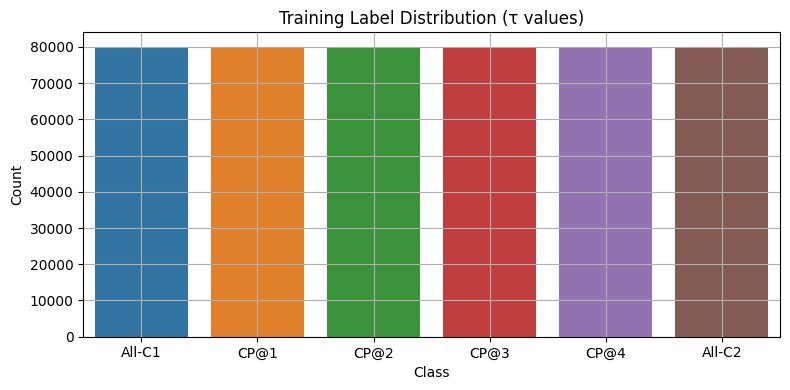

Training Epochs:   2%|▏         | 1/50 [00:42<34:29, 42.24s/it]

Epoch  1 | Train Loss: 1.7931 | Val Accuracy: 0.1761


Training Epochs:   4%|▍         | 2/50 [01:24<33:42, 42.14s/it]

Epoch  2 | Train Loss: 1.7152 | Val Accuracy: 0.3296


Training Epochs:   6%|▌         | 3/50 [02:06<32:55, 42.02s/it]

Epoch  3 | Train Loss: 1.4669 | Val Accuracy: 0.4445


Training Epochs:   8%|▊         | 4/50 [02:48<32:13, 42.04s/it]

Epoch  4 | Train Loss: 1.3295 | Val Accuracy: 0.5276


Training Epochs:  10%|█         | 5/50 [03:30<31:34, 42.09s/it]

Epoch  5 | Train Loss: 1.2283 | Val Accuracy: 0.5815


Training Epochs:  12%|█▏        | 6/50 [04:12<30:58, 42.24s/it]

Epoch  6 | Train Loss: 1.1497 | Val Accuracy: 0.6151


Training Epochs:  14%|█▍        | 7/50 [04:55<30:17, 42.27s/it]

Epoch  7 | Train Loss: 1.0952 | Val Accuracy: 0.6296


Training Epochs:  16%|█▌        | 8/50 [05:37<29:35, 42.28s/it]

Epoch  8 | Train Loss: 1.0625 | Val Accuracy: 0.6408


Training Epochs:  18%|█▊        | 9/50 [06:19<28:54, 42.31s/it]

Epoch  9 | Train Loss: 1.0369 | Val Accuracy: 0.6469


Training Epochs:  20%|██        | 10/50 [07:01<28:08, 42.20s/it]

Epoch 10 | Train Loss: 1.0144 | Val Accuracy: 0.6547


Training Epochs:  22%|██▏       | 11/50 [07:43<27:20, 42.06s/it]

Epoch 11 | Train Loss: 0.9976 | Val Accuracy: 0.6597


Training Epochs:  24%|██▍       | 12/50 [08:25<26:35, 41.99s/it]

Epoch 12 | Train Loss: 0.9853 | Val Accuracy: 0.6628


Training Epochs:  26%|██▌       | 13/50 [09:07<25:56, 42.06s/it]

Epoch 13 | Train Loss: 0.9731 | Val Accuracy: 0.6634


Training Epochs:  28%|██▊       | 14/50 [09:49<25:13, 42.04s/it]

Epoch 14 | Train Loss: 0.9645 | Val Accuracy: 0.6669


Training Epochs:  30%|███       | 15/50 [10:32<24:34, 42.13s/it]

Epoch 15 | Train Loss: 0.9584 | Val Accuracy: 0.6685


Training Epochs:  32%|███▏      | 16/50 [11:13<23:50, 42.06s/it]

Epoch 16 | Train Loss: 0.9513 | Val Accuracy: 0.6721


Training Epochs:  34%|███▍      | 17/50 [11:55<23:06, 42.00s/it]

Epoch 17 | Train Loss: 0.9449 | Val Accuracy: 0.6716


Training Epochs:  36%|███▌      | 18/50 [12:37<22:24, 42.00s/it]

Epoch 18 | Train Loss: 0.9389 | Val Accuracy: 0.6710


Training Epochs:  38%|███▊      | 19/50 [13:19<21:40, 41.96s/it]

Epoch 19 | Train Loss: 0.9329 | Val Accuracy: 0.6743


Training Epochs:  40%|████      | 20/50 [14:01<20:59, 41.98s/it]

Epoch 20 | Train Loss: 0.9269 | Val Accuracy: 0.6737


Training Epochs:  42%|████▏     | 21/50 [14:43<20:19, 42.06s/it]

Epoch 21 | Train Loss: 0.9223 | Val Accuracy: 0.6774


Training Epochs:  44%|████▍     | 22/50 [15:25<19:36, 42.01s/it]

Epoch 22 | Train Loss: 0.9164 | Val Accuracy: 0.6784


Training Epochs:  46%|████▌     | 23/50 [16:07<18:53, 41.99s/it]

Epoch 23 | Train Loss: 0.9110 | Val Accuracy: 0.6828


Training Epochs:  48%|████▊     | 24/50 [16:49<18:11, 41.98s/it]

Epoch 24 | Train Loss: 0.9046 | Val Accuracy: 0.6830


Training Epochs:  50%|█████     | 25/50 [17:31<17:30, 42.04s/it]

Epoch 25 | Train Loss: 0.8982 | Val Accuracy: 0.6880


Training Epochs:  52%|█████▏    | 26/50 [18:13<16:48, 42.01s/it]

Epoch 26 | Train Loss: 0.8926 | Val Accuracy: 0.6880


Training Epochs:  54%|█████▍    | 27/50 [18:55<16:06, 42.04s/it]

Epoch 27 | Train Loss: 0.8866 | Val Accuracy: 0.6909


Training Epochs:  56%|█████▌    | 28/50 [19:38<15:26, 42.11s/it]

Epoch 28 | Train Loss: 0.8815 | Val Accuracy: 0.6913


Training Epochs:  58%|█████▊    | 29/50 [20:20<14:43, 42.06s/it]

Epoch 29 | Train Loss: 0.8774 | Val Accuracy: 0.6910


Training Epochs:  60%|██████    | 30/50 [21:02<14:00, 42.03s/it]

Epoch 30 | Train Loss: 0.8740 | Val Accuracy: 0.6941


Training Epochs:  62%|██████▏   | 31/50 [21:44<13:18, 42.01s/it]

Epoch 31 | Train Loss: 0.8692 | Val Accuracy: 0.6941


Training Epochs:  64%|██████▍   | 32/50 [22:26<12:36, 42.04s/it]

Epoch 32 | Train Loss: 0.8674 | Val Accuracy: 0.6964


Training Epochs:  66%|██████▌   | 33/50 [23:08<11:53, 41.98s/it]

Epoch 33 | Train Loss: 0.8624 | Val Accuracy: 0.6959


Training Epochs:  68%|██████▊   | 34/50 [23:50<11:11, 42.00s/it]

Epoch 34 | Train Loss: 0.8610 | Val Accuracy: 0.6991


Training Epochs:  70%|███████   | 35/50 [24:32<10:29, 41.99s/it]

Epoch 35 | Train Loss: 0.8577 | Val Accuracy: 0.7023


Training Epochs:  72%|███████▏  | 36/50 [25:13<09:47, 41.96s/it]

Epoch 36 | Train Loss: 0.8537 | Val Accuracy: 0.7014


Training Epochs:  74%|███████▍  | 37/50 [25:55<09:05, 41.92s/it]

Epoch 37 | Train Loss: 0.8504 | Val Accuracy: 0.7018


Training Epochs:  76%|███████▌  | 38/50 [26:37<08:22, 41.87s/it]

Epoch 38 | Train Loss: 0.8485 | Val Accuracy: 0.7031


Training Epochs:  78%|███████▊  | 39/50 [27:19<07:40, 41.89s/it]

Epoch 39 | Train Loss: 0.8454 | Val Accuracy: 0.7048


Training Epochs:  80%|████████  | 40/50 [28:01<06:59, 41.93s/it]

Epoch 40 | Train Loss: 0.8430 | Val Accuracy: 0.7052


Training Epochs:  82%|████████▏ | 41/50 [28:43<06:17, 41.96s/it]

Epoch 41 | Train Loss: 0.8404 | Val Accuracy: 0.7069


Training Epochs:  84%|████████▍ | 42/50 [29:25<05:35, 41.93s/it]

Epoch 42 | Train Loss: 0.8380 | Val Accuracy: 0.7071


Training Epochs:  86%|████████▌ | 43/50 [30:07<04:53, 41.99s/it]

Epoch 43 | Train Loss: 0.8364 | Val Accuracy: 0.7087


Training Epochs:  88%|████████▊ | 44/50 [30:49<04:11, 41.95s/it]

Epoch 44 | Train Loss: 0.8333 | Val Accuracy: 0.7060


Training Epochs:  88%|████████▊ | 44/50 [31:31<04:17, 42.98s/it]

Epoch 45 | Train Loss: 0.8316 | Val Accuracy: 0.7081
Early stopping triggered.



Final Test Accuracy: 0.7061



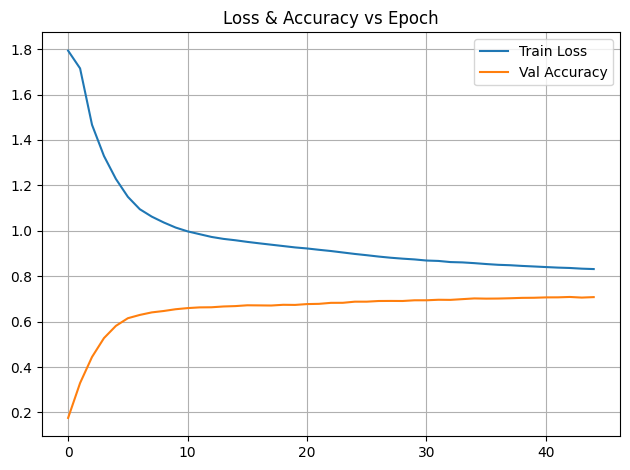

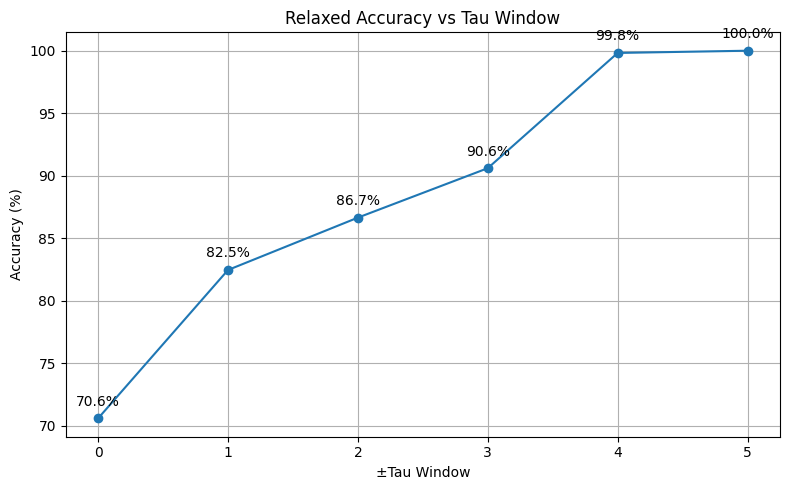

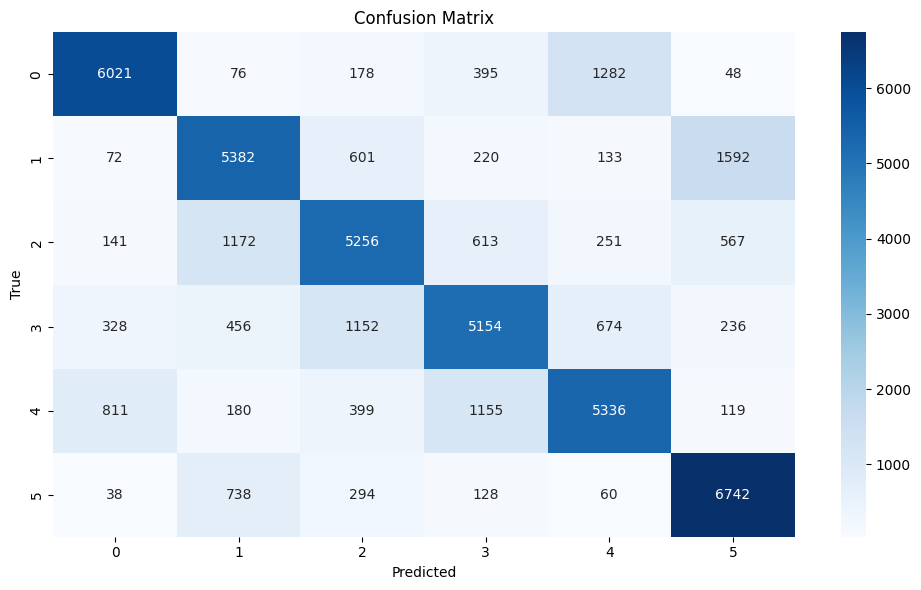


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.10_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.10_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.10_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.10_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.10_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [5]:
# ========================= Full, Download-Ready Trainer (p=0.05) =========================
# Saves state_dict, full model, TorchScript, metadata, and a ZIP bundle to /kaggle/working
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 80000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # robust init
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Include dataset tag in filenames so runs don't overwrite each other.
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]   # e.g., "bsc_p0.05_codewords1"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) full pickled model (environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) bundle to ZIP (one-click download from Output panel)
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================


***T = 5, p = 0.10, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 16.3, 42.7, 67.8, 85.3, 95.5, 100.0
For N'(training samples/class) = 2000     Accuracy = 16.1, 45.5, 66.2, 83.8, 94.3, 100.0
For N'(training samples/class) = 3000     Accuracy = 16.4,
For N'(training samples/class) = 4000     Accuracy = 16.5, 
For N'(training samples/class) = 5000     Accuracy = 16.9, 47.3, 63.5, 85.3, 95.7, 100.0
For N'(training samples/class) = 6000     Accuracy = 16.7, 48.5, 64.4, 83,8, 94.6, 100.0
For N'(training samples/class) = 8000     Accuracy = 16.9, 42.6, 64.4, 81.4, 93.3, 100.0
For N'(training samples/class) = 10000     Accuracy = 56.1, 73.5, 80.4, 86.6, 99.7, 100.0
For N'(training samples/class) = 12000     Accuracy = 59.1, 74.6, 81.3, 87.4, 99.6, 100.0
For N'(training samples/class) = 15000     Accuracy = 
For N'(training samples/class) = 18000     Accuracy = 62.4, 77.5, 82.8, 88.3, 99.7, 100.0 
For N'(training samples/class) = 20000     Accuracy = 
For N'(training samples/class) = 22000     Accuracy = 64.0, 78.2, 83.5, 88.5, 99.7, 100.0
For N'(training samples/class) = 24000     Accuracy = 
For N'(training samples/class) = 26000     Accuracy = 
For N'(training samples/class) = 28000     Accuracy = 65.9, 79.4, 84.2, 88.9, 99.6, 100.0
For N'(training samples/class) = 50000     Accuracy = 70.0, 82.0, 86.5, 90.4, 99.7, 100.0
</pre>

## p = 0.20

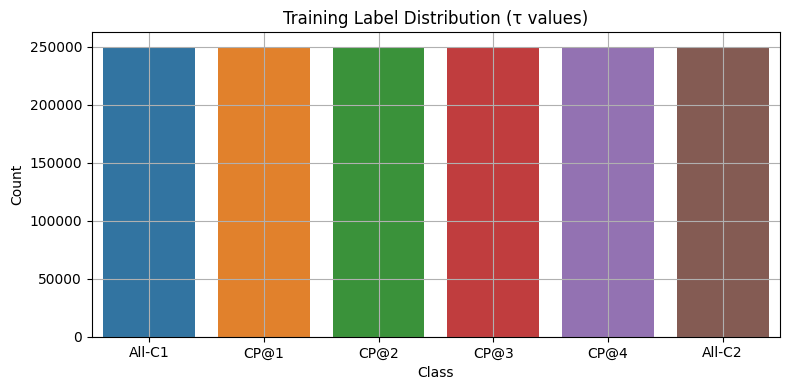

Training Epochs:   2%|▏         | 1/50 [02:09<1:45:54, 129.69s/it]

Epoch  1 | Train Loss: 1.7924 | Val Accuracy: 0.1658


Training Epochs:   4%|▍         | 2/50 [04:20<1:44:03, 130.08s/it]

Epoch  2 | Train Loss: 1.7887 | Val Accuracy: 0.1917


Training Epochs:   6%|▌         | 3/50 [06:29<1:41:41, 129.83s/it]

Epoch  3 | Train Loss: 1.7776 | Val Accuracy: 0.2047


Training Epochs:   8%|▊         | 4/50 [08:39<1:39:26, 129.71s/it]

Epoch  4 | Train Loss: 1.7632 | Val Accuracy: 0.2435


Training Epochs:  10%|█         | 5/50 [10:48<1:37:12, 129.61s/it]

Epoch  5 | Train Loss: 1.7127 | Val Accuracy: 0.2789


Training Epochs:  12%|█▏        | 6/50 [12:59<1:35:16, 129.93s/it]

Epoch  6 | Train Loss: 1.6704 | Val Accuracy: 0.2999


Training Epochs:  14%|█▍        | 7/50 [15:09<1:33:09, 129.99s/it]

Epoch  7 | Train Loss: 1.6415 | Val Accuracy: 0.3155


Training Epochs:  16%|█▌        | 8/50 [17:19<1:31:00, 130.01s/it]

Epoch  8 | Train Loss: 1.6227 | Val Accuracy: 0.3295


Training Epochs:  18%|█▊        | 9/50 [19:29<1:28:54, 130.11s/it]

Epoch  9 | Train Loss: 1.6077 | Val Accuracy: 0.3423


Training Epochs:  20%|██        | 10/50 [21:38<1:26:34, 129.87s/it]

Epoch 10 | Train Loss: 1.5972 | Val Accuracy: 0.3505


Training Epochs:  22%|██▏       | 11/50 [23:48<1:24:25, 129.88s/it]

Epoch 11 | Train Loss: 1.5899 | Val Accuracy: 0.3570


Training Epochs:  24%|██▍       | 12/50 [25:58<1:22:17, 129.93s/it]

Epoch 12 | Train Loss: 1.5848 | Val Accuracy: 0.3602


Training Epochs:  26%|██▌       | 13/50 [28:08<1:20:01, 129.77s/it]

Epoch 13 | Train Loss: 1.5813 | Val Accuracy: 0.3638


Training Epochs:  28%|██▊       | 14/50 [30:18<1:17:54, 129.85s/it]

Epoch 14 | Train Loss: 1.5776 | Val Accuracy: 0.3643


Training Epochs:  30%|███       | 15/50 [32:27<1:15:41, 129.76s/it]

Epoch 15 | Train Loss: 1.5747 | Val Accuracy: 0.3668


Training Epochs:  32%|███▏      | 16/50 [34:37<1:13:32, 129.78s/it]

Epoch 16 | Train Loss: 1.5721 | Val Accuracy: 0.3679


Training Epochs:  34%|███▍      | 17/50 [36:46<1:11:15, 129.57s/it]

Epoch 17 | Train Loss: 1.5703 | Val Accuracy: 0.3683


Training Epochs:  36%|███▌      | 18/50 [38:56<1:09:09, 129.66s/it]

Epoch 18 | Train Loss: 1.5682 | Val Accuracy: 0.3686


Training Epochs:  36%|███▌      | 18/50 [41:06<1:13:04, 137.01s/it]

Epoch 19 | Train Loss: 1.5670 | Val Accuracy: 0.3682
Early stopping triggered.



Final Test Accuracy: 0.3661



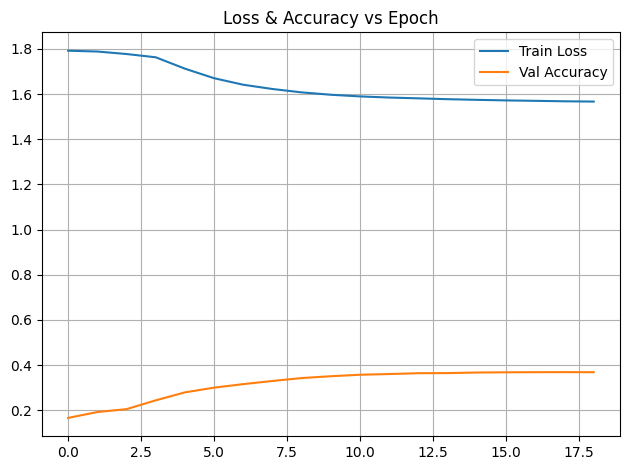

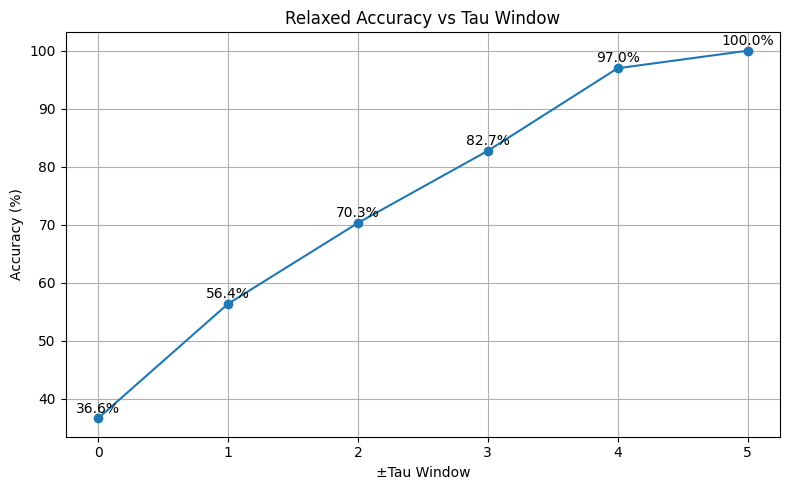

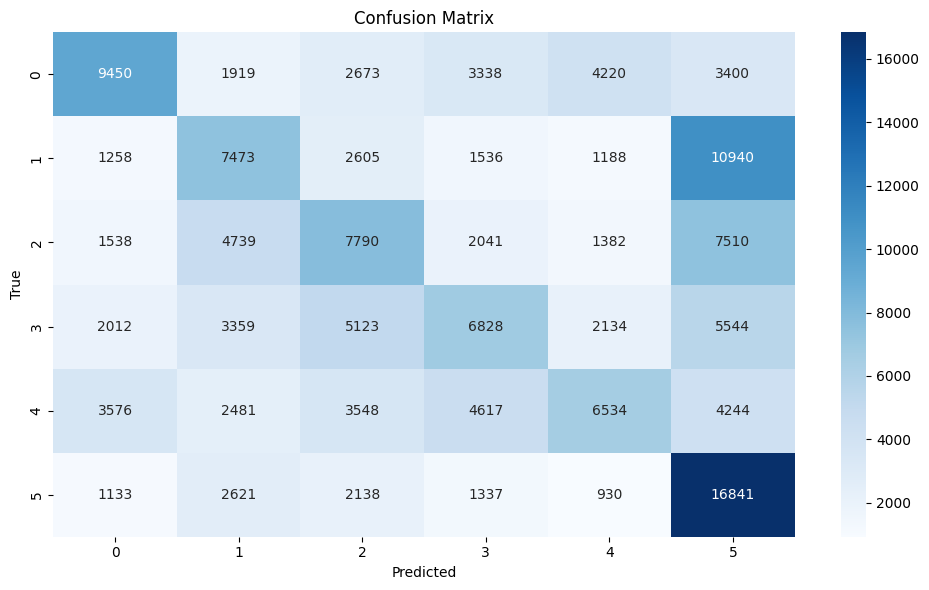


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.20_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.20_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.20_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.20_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.20_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [7]:
# ========================= Full, Download-Ready Trainer (p=0.05) =========================
# Saves state_dict, full model, TorchScript, metadata, and a ZIP bundle to /kaggle/working
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 250000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.20_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.20_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # robust init
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Include dataset tag in filenames so runs don't overwrite each other.
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]   # e.g., "bsc_p0.05_codewords1"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) full pickled model (environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) bundle to ZIP (one-click download from Output panel)
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================


***T = 5, p = 0.20, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 17.5, 46.0, 72.2, 87.5, 96.3, 100.0
For N'(training samples/class) = 2000     Accuracy = 
For N'(training samples/class) = 3000     Accuracy = 
For N'(training samples/class) = 4000     Accuracy = 
For N'(training samples/class) = 5000     Accuracy = 16.1, 44.8, 66.7, 83.0, 95.0, 100.0
For N'(training samples/class) = 6000     Accuracy = 
For N'(training samples/class) = 8000     Accuracy = 
For N'(training samples/class) = 10000     Accuracy = 16.4, 45.0, 66.9, 83.6, 94.5, 100.0 
For N'(training samples/class) = 11000     Accuracy = 
For N'(training samples/class) = 15000     Accuracy = 16.4, 43.6, 67.9, 85.0, 93.7, 100.0
For N'(training samples/class) = 17000     Accuracy = 
For N'(training samples/class) = 18000     Accuracy = 
For N'(training samples/class) = 20000     Accuracy = 16.9, 48.2, 70.0, 86.1, 97.6, 100.0
For N'(training samples/class) = 22000     Accuracy = 
For N'(training samples/class) = 24000     Accuracy = 
For N'(training samples/class) = 26000     Accuracy = 
For N'(training samples/class) = 28000     Accuracy = 
For N'(training samples/class) = 30000     Accuracy = 
For N'(training samples/class) = 32000     Accuracy = 
For N'(training samples/class) = 35000     Accuracy = 16.9, 48.2, 70.0, 86.1, 97.6, 100.0
For N'(training samples/class) = 50000     Accuracy = 16.9, 44.4, 64.3, 80.8, 94,6, 100.0 
For N'(training samples/class) = 100000     Accuracy = 34.9, 55.4, 69.6, 82.1, 96.9, 100.0
For N'(training samples/class) = 150000     Accuracy = 35.9, 55.8, 70.0, 82.3, 96.8, 100.0
For N'(training samples/class) = 200000     Accuracy = 36.9, 56.8, 70.4, 82.6, 97.1, 100.0
</pre>

## Summary Plots (for T = 5, CL=15) : CNN Architecture 

### All the data accumulated 

## p = 0.001

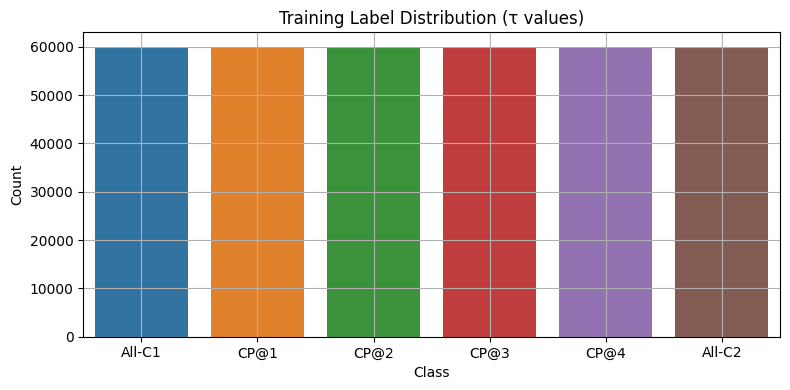

Training Epochs:   2%|▏         | 1/50 [00:33<27:00, 33.07s/it]

Epoch  1 | Train Loss: 1.7936 | Val Accuracy: 0.1688


Training Epochs:   4%|▍         | 2/50 [01:05<26:21, 32.95s/it]

Epoch  2 | Train Loss: 1.7916 | Val Accuracy: 0.1813


Training Epochs:   6%|▌         | 3/50 [01:38<25:44, 32.87s/it]

Epoch  3 | Train Loss: 1.7597 | Val Accuracy: 0.3518


Training Epochs:   8%|▊         | 4/50 [02:11<25:16, 32.96s/it]

Epoch  4 | Train Loss: 1.2689 | Val Accuracy: 0.5773


Training Epochs:  10%|█         | 5/50 [02:44<24:40, 32.90s/it]

Epoch  5 | Train Loss: 0.9930 | Val Accuracy: 0.7336


Training Epochs:  12%|█▏        | 6/50 [03:17<24:04, 32.84s/it]

Epoch  6 | Train Loss: 0.7429 | Val Accuracy: 0.8362


Training Epochs:  14%|█▍        | 7/50 [03:50<23:34, 32.89s/it]

Epoch  7 | Train Loss: 0.5504 | Val Accuracy: 0.8602


Training Epochs:  16%|█▌        | 8/50 [04:23<22:59, 32.86s/it]

Epoch  8 | Train Loss: 0.5076 | Val Accuracy: 0.8647


Training Epochs:  18%|█▊        | 9/50 [04:56<22:28, 32.88s/it]

Epoch  9 | Train Loss: 0.4593 | Val Accuracy: 0.8914


Training Epochs:  20%|██        | 10/50 [05:28<21:54, 32.86s/it]

Epoch 10 | Train Loss: 0.3999 | Val Accuracy: 0.9156


Training Epochs:  22%|██▏       | 11/50 [06:01<21:22, 32.87s/it]

Epoch 11 | Train Loss: 0.3537 | Val Accuracy: 0.9248


Training Epochs:  24%|██▍       | 12/50 [06:34<20:49, 32.89s/it]

Epoch 12 | Train Loss: 0.3342 | Val Accuracy: 0.9297


Training Epochs:  26%|██▌       | 13/50 [07:07<20:15, 32.86s/it]

Epoch 13 | Train Loss: 0.3224 | Val Accuracy: 0.9306


Training Epochs:  28%|██▊       | 14/50 [07:40<19:40, 32.79s/it]

Epoch 14 | Train Loss: 0.3161 | Val Accuracy: 0.9314


Training Epochs:  30%|███       | 15/50 [08:12<19:00, 32.57s/it]

Epoch 15 | Train Loss: 0.3110 | Val Accuracy: 0.9316


Training Epochs:  32%|███▏      | 16/50 [08:44<18:26, 32.53s/it]

Epoch 16 | Train Loss: 0.3067 | Val Accuracy: 0.9319


Training Epochs:  34%|███▍      | 17/50 [09:16<17:49, 32.39s/it]

Epoch 17 | Train Loss: 0.3042 | Val Accuracy: 0.9319


Training Epochs:  36%|███▌      | 18/50 [09:49<17:16, 32.40s/it]

Epoch 18 | Train Loss: 0.2996 | Val Accuracy: 0.9326


Training Epochs:  38%|███▊      | 19/50 [10:21<16:46, 32.46s/it]

Epoch 19 | Train Loss: 0.2957 | Val Accuracy: 0.9330


Training Epochs:  40%|████      | 20/50 [10:54<16:16, 32.56s/it]

Epoch 20 | Train Loss: 0.2927 | Val Accuracy: 0.9329


Training Epochs:  40%|████      | 20/50 [11:27<17:10, 34.36s/it]

Epoch 21 | Train Loss: 0.2887 | Val Accuracy: 0.9332
Early stopping triggered.



Final Test Accuracy: 0.9312


Saved artifacts:
  state_dict -> /kaggle/working/cpd_windowT5_n15_state.pth
  full model -> /kaggle/working/cpd_windowT5_n15_full.pth
  TorchScript -> /kaggle/working/cpd_windowT5_model.pt
  metadata -> /kaggle/working/cpd_windowT5_n15_meta.json


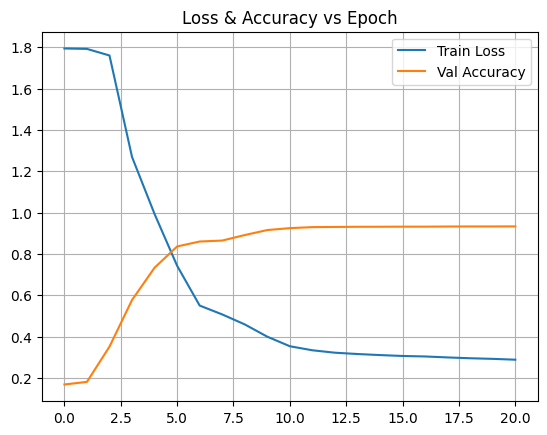

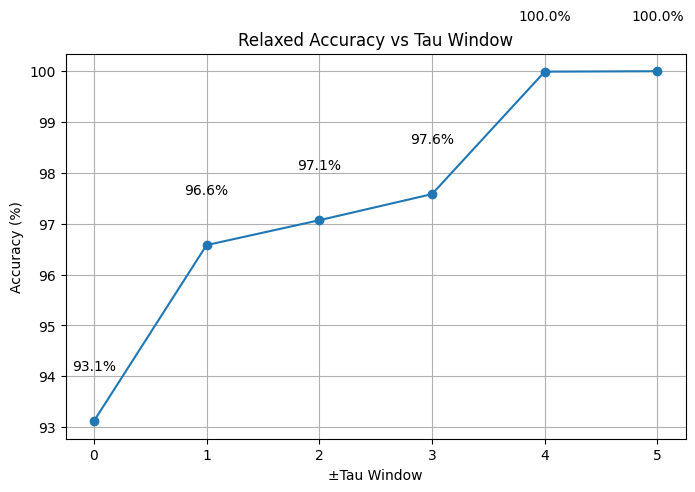

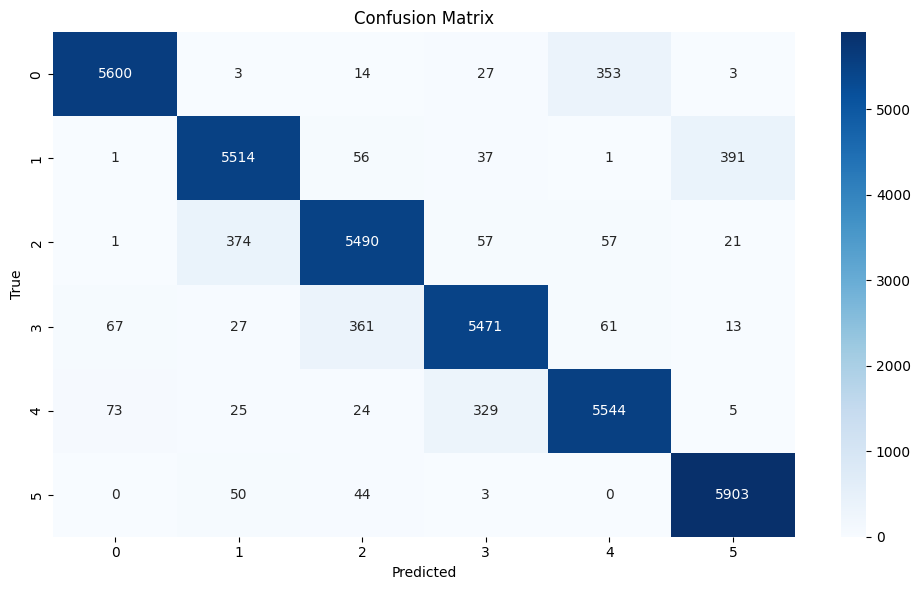

In [6]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ================== Configuration ==================
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 60000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples
BATCH_SIZE   = 64
PATIENCE     = 5
VAL_DELTA    = 0.002
LEARNING_RATE= 1e-4
MAX_EPOCHS   = 50

# ================== Set Seeds ==================
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ================== Load Data ==================
csv1 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.001_C1_n15_k11.csv").values
csv2 = pd.read_csv("/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.001_C2_n15_k7.csv").values
FEATURE_SIZE = csv1.shape[1]  # n

# ================== Dataset Generator ==================
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    """
    Returns:
      Data:  shape (N_per_class*(T+1), T, n)
      Labels: length N_per_class*(T+1), labels in {0,1,...,T}
        class 0  : all-C1
        class T  : all-C2
        class t  : changepoint at t (1..T-1)
    """
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                idx = np.random.choice(len(csv1_data), T, replace=True)
                sample = csv1_data[idx]
            elif cls == T:
                idx = np.random.choice(len(csv2_data), T, replace=True)
                sample = csv2_data[idx]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ================== Create Datasets ==================
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ================== Plot Label Distribution ==================
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(
    ticks=np.arange(NUM_CLASSES),
    labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
)
plt.grid(True)
plt.tight_layout()
plt.show()

# ================== Dataset Wrapper ==================
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, T, n)
        self.y = torch.tensor(y, dtype=torch.long)     # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ================== Model ==================
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2   = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc  = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 ch
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)     # logits over {0,...,T}
        )

    def forward(self, x):
        # x: (B, T, n) -> (B, n, T) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)  # (B, C, 1)
        return self.classifier(x)    # (B, T+1)

# ================== Training ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    # ---- train
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    # ---- early stopping check
    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ================== Evaluation ==================
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ================== Save Artifacts (Kaggle) ==================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Use a basename that matches your inference script expectation
TS_PATH    = os.path.join(OUTPUT_DIR, f"cpd_windowT{T}_model.pt")  # TorchScript (for cpd_neural_refine.py)
STATE_PATH = os.path.join(OUTPUT_DIR, f"cpd_windowT{T}_n{FEATURE_SIZE}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"cpd_windowT{T}_n{FEATURE_SIZE}_full.pth")
META_PATH  = os.path.join(OUTPUT_DIR, f"cpd_windowT{T}_n{FEATURE_SIZE}_meta.json")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    # Fallback to trace if scripting fails
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc)
    }, f, indent=2)

print("\nSaved artifacts:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)

# ================== Relaxed Accuracy & Plots ==================
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================

## p = 0.005

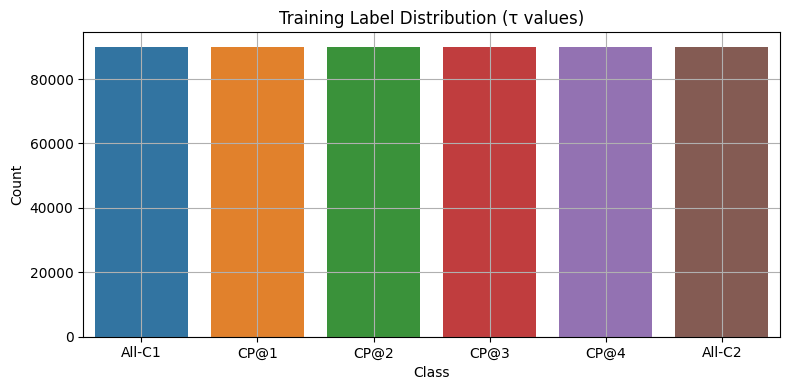

Training Epochs:   2%|▏         | 1/50 [00:46<38:17, 46.88s/it]

Epoch  1 | Train Loss: 1.7931 | Val Accuracy: 0.1709


Training Epochs:   4%|▍         | 2/50 [01:34<37:40, 47.09s/it]

Epoch  2 | Train Loss: 1.7856 | Val Accuracy: 0.2810


Training Epochs:   6%|▌         | 3/50 [02:21<36:54, 47.12s/it]

Epoch  3 | Train Loss: 1.3518 | Val Accuracy: 0.5446


Training Epochs:   8%|▊         | 4/50 [03:08<36:07, 47.11s/it]

Epoch  4 | Train Loss: 0.9847 | Val Accuracy: 0.7846


Training Epochs:  10%|█         | 5/50 [03:55<35:26, 47.25s/it]

Epoch  5 | Train Loss: 0.6223 | Val Accuracy: 0.8680


Training Epochs:  12%|█▏        | 6/50 [04:42<34:36, 47.19s/it]

Epoch  6 | Train Loss: 0.5230 | Val Accuracy: 0.8729


Training Epochs:  14%|█▍        | 7/50 [05:29<33:46, 47.13s/it]

Epoch  7 | Train Loss: 0.4930 | Val Accuracy: 0.8792


Training Epochs:  16%|█▌        | 8/50 [06:17<32:58, 47.11s/it]

Epoch  8 | Train Loss: 0.4585 | Val Accuracy: 0.8917


Training Epochs:  18%|█▊        | 9/50 [07:04<32:10, 47.10s/it]

Epoch  9 | Train Loss: 0.4379 | Val Accuracy: 0.8964


Training Epochs:  20%|██        | 10/50 [07:51<31:25, 47.15s/it]

Epoch 10 | Train Loss: 0.4265 | Val Accuracy: 0.8980


Training Epochs:  22%|██▏       | 11/50 [08:38<30:36, 47.10s/it]

Epoch 11 | Train Loss: 0.4171 | Val Accuracy: 0.8987


Training Epochs:  24%|██▍       | 12/50 [09:25<29:47, 47.03s/it]

Epoch 12 | Train Loss: 0.4101 | Val Accuracy: 0.9002


Training Epochs:  26%|██▌       | 13/50 [10:12<28:59, 47.00s/it]

Epoch 13 | Train Loss: 0.4041 | Val Accuracy: 0.9010


Training Epochs:  28%|██▊       | 14/50 [10:59<28:14, 47.07s/it]

Epoch 14 | Train Loss: 0.3991 | Val Accuracy: 0.9019


Training Epochs:  30%|███       | 15/50 [11:46<27:25, 47.00s/it]

Epoch 15 | Train Loss: 0.3949 | Val Accuracy: 0.9010


Training Epochs:  32%|███▏      | 16/50 [12:33<26:37, 46.98s/it]

Epoch 16 | Train Loss: 0.3904 | Val Accuracy: 0.9017


Training Epochs:  34%|███▍      | 17/50 [13:20<25:50, 46.97s/it]

Epoch 17 | Train Loss: 0.3868 | Val Accuracy: 0.9031


Training Epochs:  36%|███▌      | 18/50 [14:07<25:03, 46.98s/it]

Epoch 18 | Train Loss: 0.3830 | Val Accuracy: 0.9041


Training Epochs:  38%|███▊      | 19/50 [14:54<24:16, 46.98s/it]

Epoch 19 | Train Loss: 0.3795 | Val Accuracy: 0.9054


Training Epochs:  40%|████      | 20/50 [15:40<23:27, 46.93s/it]

Epoch 20 | Train Loss: 0.3772 | Val Accuracy: 0.9054


Training Epochs:  42%|████▏     | 21/50 [16:27<22:40, 46.90s/it]

Epoch 21 | Train Loss: 0.3738 | Val Accuracy: 0.9053


Training Epochs:  44%|████▍     | 22/50 [17:14<21:52, 46.87s/it]

Epoch 22 | Train Loss: 0.3723 | Val Accuracy: 0.9052


Training Epochs:  46%|████▌     | 23/50 [18:01<21:04, 46.83s/it]

Epoch 23 | Train Loss: 0.3699 | Val Accuracy: 0.9052


Training Epochs:  46%|████▌     | 23/50 [18:47<22:04, 49.04s/it]

Epoch 24 | Train Loss: 0.3621 | Val Accuracy: 0.9054
Early stopping triggered.



Final Test Accuracy: 0.9034


Saved artifacts:
  state_dict -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.005_C1_n15_k11_state.pth
  full model -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.005_C1_n15_k11_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.005_C1_n15_k11_model.pt
  metadata -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.005_C1_n15_k11_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.005_C1_n15_k11_artifacts.zip

These appear in the right-side 'Output' panel for download.


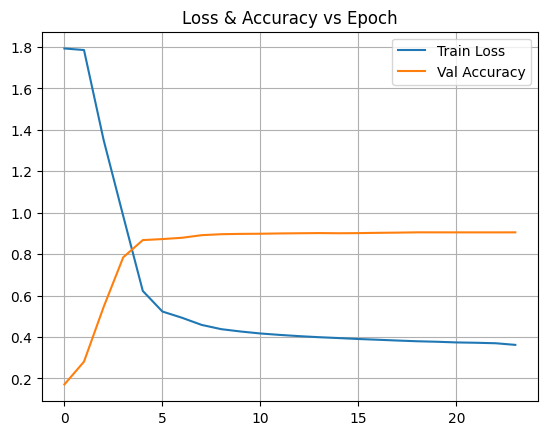

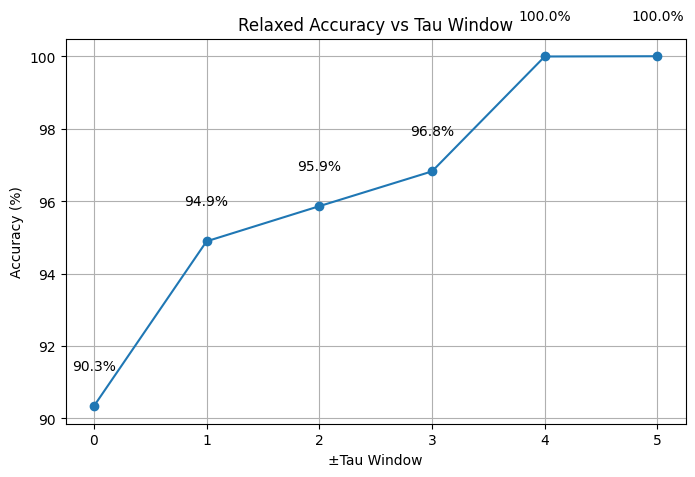

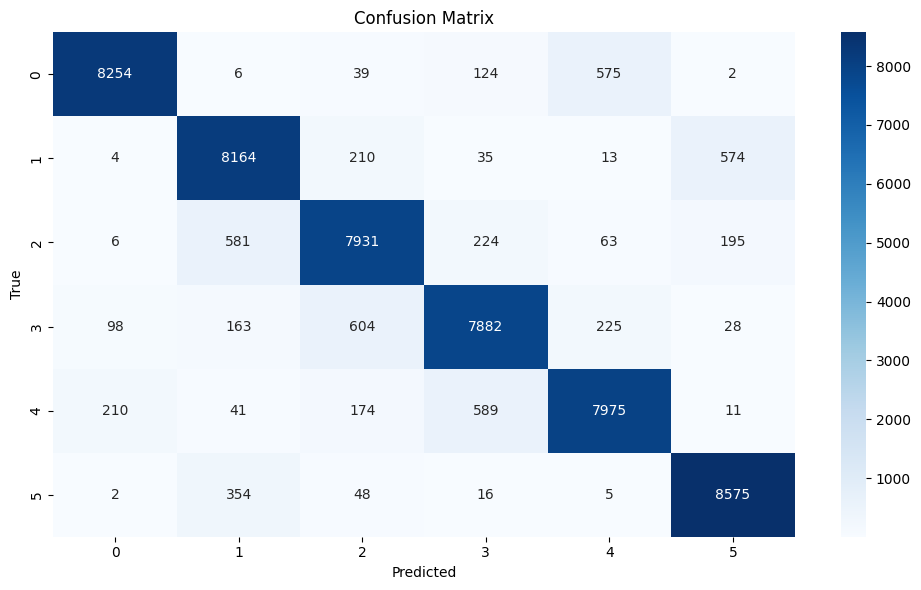

In [8]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ================== Configuration ==================
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 90000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples
BATCH_SIZE   = 64
PATIENCE     = 5
VAL_DELTA    = 0.002
LEARNING_RATE= 1e-4
MAX_EPOCHS   = 50

# ================== Set Seeds ==================
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ================== Load Data ==================
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.005_C1_n15_k11.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.005_C2_n15_k7.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]  # n

# ================== Dataset Generator ==================
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    """
    Returns:
      Data:  shape (N_per_class*(T+1), T, n)
      Labels: length N_per_class*(T+1), labels in {0,1,...,T}
        class 0  : all-C1
        class T  : all-C2
        class t  : changepoint at t (1..T-1)
    """
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                idx = np.random.choice(len(csv1_data), T, replace=True)
                sample = csv1_data[idx]
            elif cls == T:
                idx = np.random.choice(len(csv2_data), T, replace=True)
                sample = csv2_data[idx]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ================== Create Datasets ==================
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ================== Plot Label Distribution ==================
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(
    ticks=np.arange(NUM_CLASSES),
    labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
)
plt.grid(True)
plt.tight_layout()
plt.show()

# ================== Dataset Wrapper ==================
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, T, n)
        self.y = torch.tensor(y, dtype=torch.long)     # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ================== Model ==================
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2   = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc  = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 ch
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)     # logits over {0,...,T}
        )

    def forward(self, x):
        # x: (B, T, n) -> (B, n, T) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)  # (B, C, 1)
        return self.classifier(x)    # (B, T+1)

# ================== Training ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    # ---- train
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    # ---- early stopping check
    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ================== Evaluation ==================
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ================== Save Artifacts (Kaggle) ==================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset-tagged prefix (includes p-value via filename)
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]  # e.g., "bsc_p0.005_C1_n15_k11"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")   # TorchScript
STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")  # state_dict
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")   # full pickled model
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")  # metadata
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    # Fallback to trace if scripting fails
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle into a ZIP for one-click download in Kaggle "Output"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")

# ================== Relaxed Accuracy & Plots ==================
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================


## p = 0.08

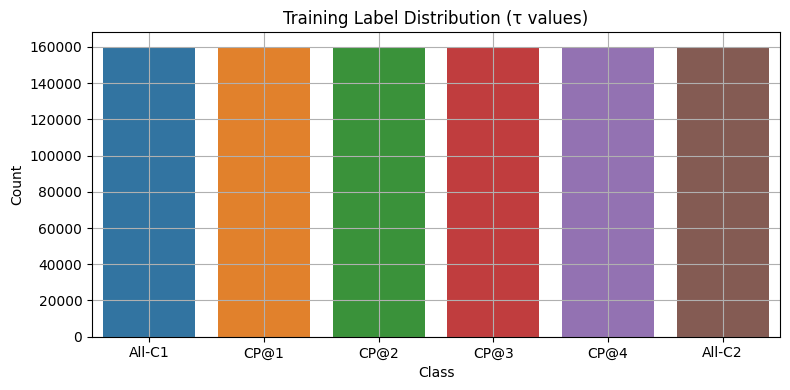

Training Epochs:   2%|▏         | 1/50 [01:21<1:06:20, 81.23s/it]

Epoch  1 | Train Loss: 1.7926 | Val Accuracy: 0.1701


Training Epochs:   4%|▍         | 2/50 [02:42<1:04:50, 81.06s/it]

Epoch  2 | Train Loss: 1.7918 | Val Accuracy: 0.1696


Training Epochs:   6%|▌         | 3/50 [04:03<1:03:32, 81.13s/it]

Epoch  3 | Train Loss: 1.7911 | Val Accuracy: 0.1806


Training Epochs:   8%|▊         | 4/50 [05:24<1:02:09, 81.08s/it]

Epoch  4 | Train Loss: 1.7539 | Val Accuracy: 0.2731


Training Epochs:  10%|█         | 5/50 [06:45<1:00:43, 80.97s/it]

Epoch  5 | Train Loss: 1.6118 | Val Accuracy: 0.3521


Training Epochs:  12%|█▏        | 6/50 [08:06<59:28, 81.11s/it]  

Epoch  6 | Train Loss: 1.5162 | Val Accuracy: 0.4042


Training Epochs:  14%|█▍        | 7/50 [09:27<58:08, 81.12s/it]

Epoch  7 | Train Loss: 1.4295 | Val Accuracy: 0.4513


Training Epochs:  16%|█▌        | 8/50 [10:49<56:50, 81.19s/it]

Epoch  8 | Train Loss: 1.3740 | Val Accuracy: 0.4756


Training Epochs:  18%|█▊        | 9/50 [12:09<55:23, 81.05s/it]

Epoch  9 | Train Loss: 1.3294 | Val Accuracy: 0.5068


Training Epochs:  20%|██        | 10/50 [13:30<54:01, 81.05s/it]

Epoch 10 | Train Loss: 1.2892 | Val Accuracy: 0.5310


Training Epochs:  22%|██▏       | 11/50 [14:51<52:37, 80.97s/it]

Epoch 11 | Train Loss: 1.2542 | Val Accuracy: 0.5567


Training Epochs:  24%|██▍       | 12/50 [16:12<51:12, 80.85s/it]

Epoch 12 | Train Loss: 1.2200 | Val Accuracy: 0.5728


Training Epochs:  26%|██▌       | 13/50 [17:33<49:52, 80.87s/it]

Epoch 13 | Train Loss: 1.1889 | Val Accuracy: 0.5838


Training Epochs:  28%|██▊       | 14/50 [18:53<48:30, 80.86s/it]

Epoch 14 | Train Loss: 1.1644 | Val Accuracy: 0.5936


Training Epochs:  30%|███       | 15/50 [20:14<47:07, 80.79s/it]

Epoch 15 | Train Loss: 1.1455 | Val Accuracy: 0.6016


Training Epochs:  32%|███▏      | 16/50 [21:35<45:45, 80.76s/it]

Epoch 16 | Train Loss: 1.1304 | Val Accuracy: 0.6051


Training Epochs:  34%|███▍      | 17/50 [22:56<44:29, 80.90s/it]

Epoch 17 | Train Loss: 1.1169 | Val Accuracy: 0.6078


Training Epochs:  36%|███▌      | 18/50 [24:17<43:09, 80.91s/it]

Epoch 18 | Train Loss: 1.1033 | Val Accuracy: 0.6130


Training Epochs:  38%|███▊      | 19/50 [25:38<41:47, 80.90s/it]

Epoch 19 | Train Loss: 1.0917 | Val Accuracy: 0.6150


Training Epochs:  40%|████      | 20/50 [26:59<40:30, 81.02s/it]

Epoch 20 | Train Loss: 1.0820 | Val Accuracy: 0.6172


Training Epochs:  42%|████▏     | 21/50 [28:20<39:08, 80.99s/it]

Epoch 21 | Train Loss: 1.0741 | Val Accuracy: 0.6204


Training Epochs:  44%|████▍     | 22/50 [29:41<37:44, 80.88s/it]

Epoch 22 | Train Loss: 1.0657 | Val Accuracy: 0.6218


Training Epochs:  46%|████▌     | 23/50 [31:01<36:23, 80.86s/it]

Epoch 23 | Train Loss: 1.0580 | Val Accuracy: 0.6239


Training Epochs:  48%|████▊     | 24/50 [32:22<35:03, 80.91s/it]

Epoch 24 | Train Loss: 1.0505 | Val Accuracy: 0.6219


Training Epochs:  50%|█████     | 25/50 [33:43<33:41, 80.88s/it]

Epoch 25 | Train Loss: 1.0440 | Val Accuracy: 0.6245


Training Epochs:  52%|█████▏    | 26/50 [35:04<32:18, 80.78s/it]

Epoch 26 | Train Loss: 1.0372 | Val Accuracy: 0.6253


Training Epochs:  54%|█████▍    | 27/50 [36:25<30:58, 80.78s/it]

Epoch 27 | Train Loss: 1.0321 | Val Accuracy: 0.6240


Training Epochs:  54%|█████▍    | 27/50 [37:45<32:10, 83.92s/it]

Epoch 28 | Train Loss: 1.0255 | Val Accuracy: 0.6241
Early stopping triggered.



Final Test Accuracy: 0.6257


Saved artifacts:
  state_dict -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.08_C1_n15_k11_state.pth
  full model -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.08_C1_n15_k11_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.08_C1_n15_k11_model.pt
  metadata -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.08_C1_n15_k11_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.08_C1_n15_k11_artifacts.zip

These appear in the right-side 'Output' panel for download.


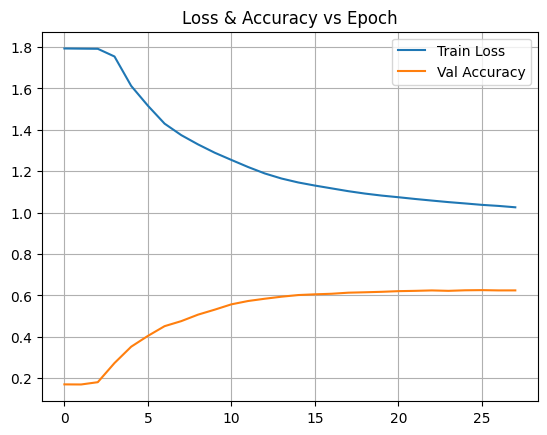

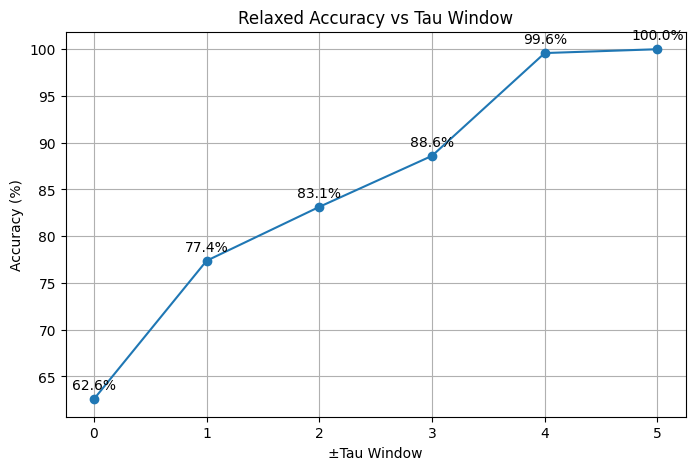

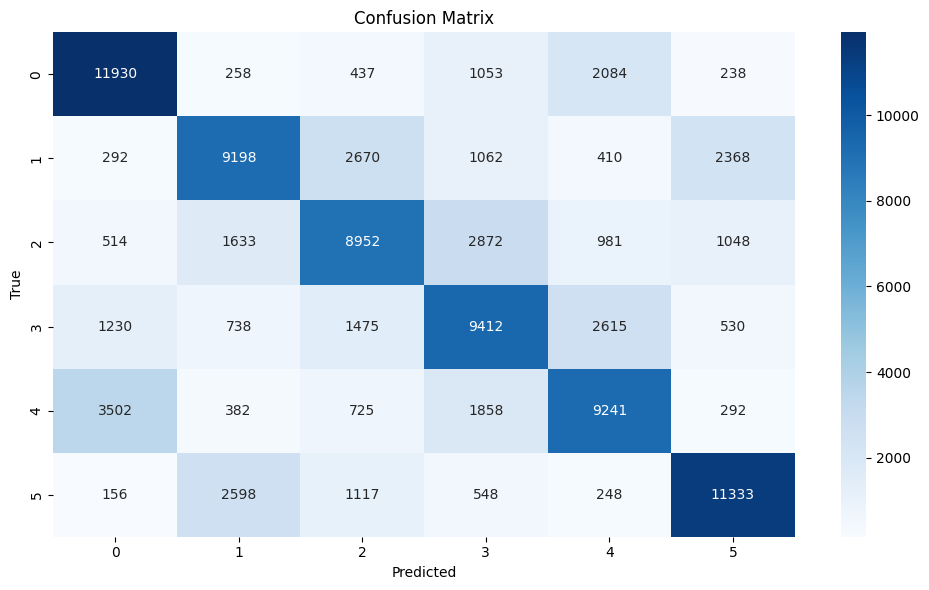

In [9]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ================== Configuration ==================
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 160000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples
BATCH_SIZE   = 64
PATIENCE     = 5
VAL_DELTA    = 0.002
LEARNING_RATE= 1e-4
MAX_EPOCHS   = 50

# ================== Set Seeds ==================
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ================== Load Data ==================
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.08_C1_n15_k11.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.08_C2_n15_k7.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]  # n

# ================== Dataset Generator ==================
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    """
    Returns:
      Data:  shape (N_per_class*(T+1), T, n)
      Labels: length N_per_class*(T+1), labels in {0,1,...,T}
        class 0  : all-C1
        class T  : all-C2
        class t  : changepoint at t (1..T-1)
    """
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                idx = np.random.choice(len(csv1_data), T, replace=True)
                sample = csv1_data[idx]
            elif cls == T:
                idx = np.random.choice(len(csv2_data), T, replace=True)
                sample = csv2_data[idx]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ================== Create Datasets ==================
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ================== Plot Label Distribution ==================
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(
    ticks=np.arange(NUM_CLASSES),
    labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
)
plt.grid(True)
plt.tight_layout()
plt.show()

# ================== Dataset Wrapper ==================
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, T, n)
        self.y = torch.tensor(y, dtype=torch.long)     # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ================== Model ==================
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2   = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc  = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 ch
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1d(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)     # logits over {0,...,T}
        )

    def forward(self, x):
        # x: (B, T, n) -> (B, n, T) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)  # (B, C, 1)
        return self.classifier(x)    # (B, T+1)

# ================== Training ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    # ---- train
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    # ---- early stopping check
    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ================== Evaluation ==================
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ================== Save Artifacts (Kaggle) ==================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset-tagged prefix (includes p-value via filename)
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]  # e.g., "bsc_p0.08_C1_n15_k11"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")   # TorchScript
STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")  # state_dict
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")   # full pickled model
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")  # metadata
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    # Fallback to trace if scripting fails
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything for one-click download in Kaggle Output
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")

# ================== Relaxed Accuracy & Plots ==================
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================


## p = 0.15

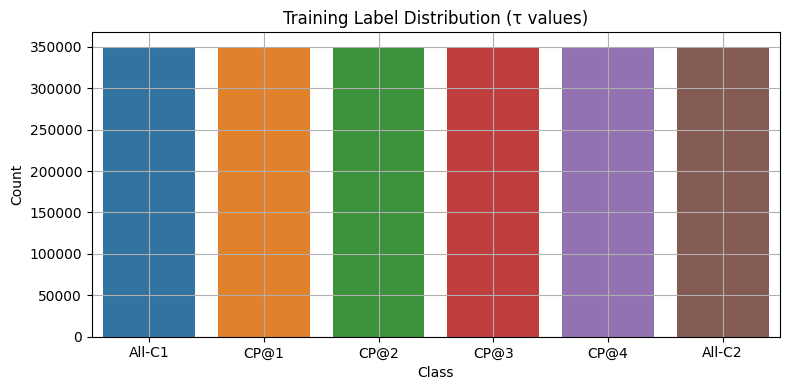

Training Epochs:   2%|▏         | 1/50 [02:58<2:25:22, 178.02s/it]

Epoch  1 | Train Loss: 1.7922 | Val Accuracy: 0.1678


Training Epochs:   4%|▍         | 2/50 [05:56<2:22:35, 178.23s/it]

Epoch  2 | Train Loss: 1.7918 | Val Accuracy: 0.1667


Training Epochs:   6%|▌         | 3/50 [08:54<2:19:36, 178.22s/it]

Epoch  3 | Train Loss: 1.7918 | Val Accuracy: 0.1667


Training Epochs:   8%|▊         | 4/50 [11:52<2:16:29, 178.04s/it]

Epoch  4 | Train Loss: 1.7918 | Val Accuracy: 0.1667


Training Epochs:  10%|█         | 5/50 [14:50<2:13:31, 178.02s/it]

Epoch  5 | Train Loss: 1.7918 | Val Accuracy: 0.1667


Training Epochs:  10%|█         | 5/50 [17:48<2:40:19, 213.78s/it]

Epoch  6 | Train Loss: 1.7918 | Val Accuracy: 0.1667
Early stopping triggered.



Final Test Accuracy: 0.1672


Saved artifacts:
  state_dict -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.15_C1_n15_k11_state.pth
  full model -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.15_C1_n15_k11_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.15_C1_n15_k11_model.pt
  metadata -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.15_C1_n15_k11_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n15_seed0_bsc_p0.15_C1_n15_k11_artifacts.zip

These appear in the right-side 'Output' panel for download.


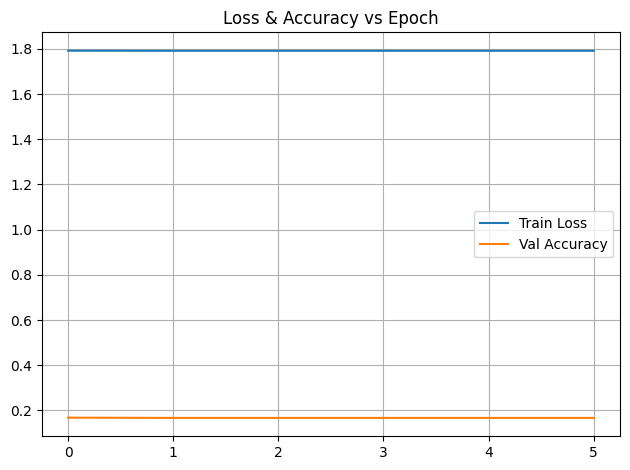

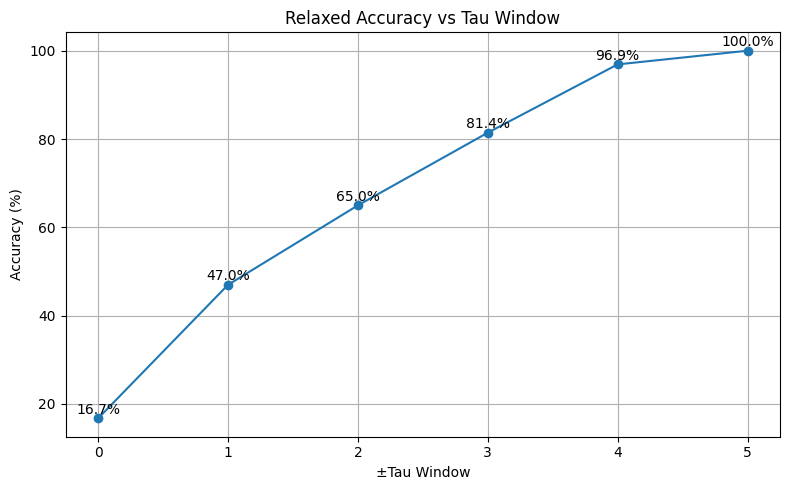

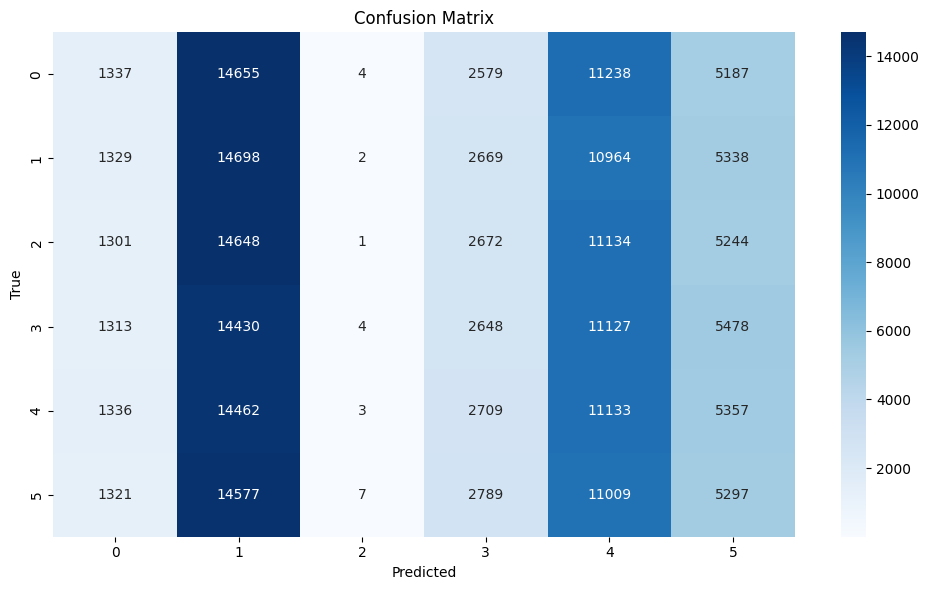

In [10]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ================== Configuration ==================
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 350000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples
BATCH_SIZE   = 64
PATIENCE     = 5
VAL_DELTA    = 0.002
LEARNING_RATE= 1e-4
MAX_EPOCHS   = 50

# ================== Set Seeds ==================
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ================== Load Data ==================
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.15_C1_n15_k11.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.15_C2_n15_k7.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]  # n

# ================== Dataset Generator ==================
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    """
    Returns:
      Data:  shape (N_per_class*(T+1), T, n)
      Labels: length N_per_class*(T+1), labels in {0,1,...,T}
        class 0  : all-C1
        class T  : all-C2
        class t  : changepoint at t (1..T-1)
    """
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                idx = np.random.choice(len(csv1_data), T, replace=True)
                sample = csv1_data[idx]
            elif cls == T:
                idx = np.random.choice(len(csv2_data), T, replace=True)
                sample = csv2_data[idx]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ================== Create Datasets ==================
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ================== Plot Label Distribution ==================
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(
    ticks=np.arange(NUM_CLASSES),
    labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
)
plt.grid(True)
plt.tight_layout()
plt.show()

# ================== Dataset Wrapper ==================
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, T, n)
        self.y = torch.tensor(y, dtype=torch.long)     # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ================== Model ==================
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2   = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc  = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 ch
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)     # logits over {0,...,T}
        )

    def forward(self, x):
        # x: (B, T, n) -> (B, n, T) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)  # (B, C, 1)
        return self.classifier(x)    # (B, T+1)

# ================== Training ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    # ---- train
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- validate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    # ---- early stopping check
    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ================== Evaluation ==================
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ================== Save Artifacts (Kaggle) ==================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset-tagged prefix (includes p-value via filename)
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]  # e.g., "bsc_p0.15_C1_n15_k11"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")   # TorchScript
STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")  # state_dict
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")   # full pickled model
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")  # metadata
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    # Fallback to trace if scripting fails
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything for one-click download in Kaggle Output
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")

# ================== Relaxed Accuracy & Plots ==================
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================


## T = 15, p = 0.01

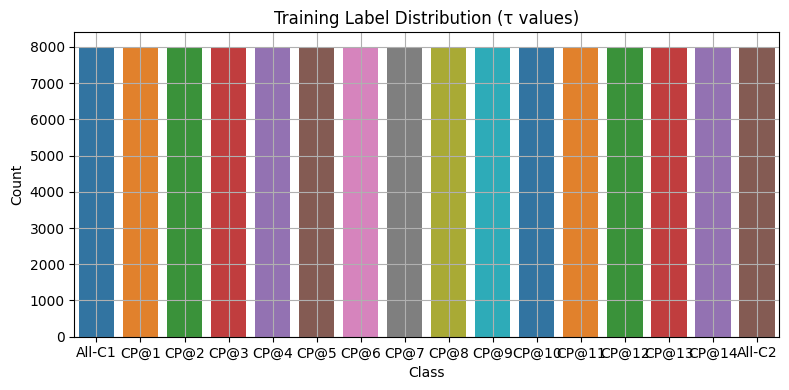

Training Epochs:   2%|▏         | 1/50 [00:11<09:18, 11.40s/it]

Epoch  1 | Train Loss: 2.7760 | Val Accuracy: 0.0677


Training Epochs:   4%|▍         | 2/50 [00:22<08:46, 10.96s/it]

Epoch  2 | Train Loss: 2.7608 | Val Accuracy: 0.1339


Training Epochs:   6%|▌         | 3/50 [00:32<08:26, 10.77s/it]

Epoch  3 | Train Loss: 2.0044 | Val Accuracy: 0.3725


Training Epochs:   8%|▊         | 4/50 [00:43<08:13, 10.72s/it]

Epoch  4 | Train Loss: 1.5540 | Val Accuracy: 0.4653


Training Epochs:  10%|█         | 5/50 [00:53<07:59, 10.66s/it]

Epoch  5 | Train Loss: 1.3580 | Val Accuracy: 0.5643


Training Epochs:  12%|█▏        | 6/50 [01:04<07:47, 10.63s/it]

Epoch  6 | Train Loss: 1.2270 | Val Accuracy: 0.6235


Training Epochs:  14%|█▍        | 7/50 [01:14<07:36, 10.62s/it]

Epoch  7 | Train Loss: 1.1389 | Val Accuracy: 0.6807


Training Epochs:  16%|█▌        | 8/50 [01:25<07:26, 10.64s/it]

Epoch  8 | Train Loss: 1.0491 | Val Accuracy: 0.7163


Training Epochs:  18%|█▊        | 9/50 [01:36<07:14, 10.60s/it]

Epoch  9 | Train Loss: 0.9726 | Val Accuracy: 0.7651


Training Epochs:  20%|██        | 10/50 [01:46<07:04, 10.60s/it]

Epoch 10 | Train Loss: 0.9031 | Val Accuracy: 0.7984


Training Epochs:  22%|██▏       | 11/50 [01:57<06:52, 10.58s/it]

Epoch 11 | Train Loss: 0.8397 | Val Accuracy: 0.8151


Training Epochs:  24%|██▍       | 12/50 [02:07<06:42, 10.59s/it]

Epoch 12 | Train Loss: 0.7815 | Val Accuracy: 0.8426


Training Epochs:  26%|██▌       | 13/50 [02:18<06:32, 10.61s/it]

Epoch 13 | Train Loss: 0.7360 | Val Accuracy: 0.8520


Training Epochs:  28%|██▊       | 14/50 [02:29<06:21, 10.60s/it]

Epoch 14 | Train Loss: 0.6884 | Val Accuracy: 0.8638


Training Epochs:  30%|███       | 15/50 [02:39<06:09, 10.55s/it]

Epoch 15 | Train Loss: 0.6507 | Val Accuracy: 0.8734


Training Epochs:  32%|███▏      | 16/50 [02:50<05:58, 10.54s/it]

Epoch 16 | Train Loss: 0.6177 | Val Accuracy: 0.8778


Training Epochs:  34%|███▍      | 17/50 [03:00<05:47, 10.54s/it]

Epoch 17 | Train Loss: 0.5871 | Val Accuracy: 0.8938


Training Epochs:  36%|███▌      | 18/50 [03:11<05:37, 10.53s/it]

Epoch 18 | Train Loss: 0.5559 | Val Accuracy: 0.8998


Training Epochs:  38%|███▊      | 19/50 [03:21<05:26, 10.53s/it]

Epoch 19 | Train Loss: 0.5348 | Val Accuracy: 0.9037


Training Epochs:  40%|████      | 20/50 [03:32<05:16, 10.53s/it]

Epoch 20 | Train Loss: 0.5124 | Val Accuracy: 0.9111


Training Epochs:  42%|████▏     | 21/50 [03:42<05:05, 10.53s/it]

Epoch 21 | Train Loss: 0.4915 | Val Accuracy: 0.9135


Training Epochs:  44%|████▍     | 22/50 [03:53<04:54, 10.52s/it]

Epoch 22 | Train Loss: 0.4783 | Val Accuracy: 0.9165


Training Epochs:  46%|████▌     | 23/50 [04:03<04:43, 10.50s/it]

Epoch 23 | Train Loss: 0.4602 | Val Accuracy: 0.9201


Training Epochs:  48%|████▊     | 24/50 [04:14<04:33, 10.50s/it]

Epoch 24 | Train Loss: 0.4432 | Val Accuracy: 0.9248


Training Epochs:  50%|█████     | 25/50 [04:24<04:22, 10.50s/it]

Epoch 25 | Train Loss: 0.4300 | Val Accuracy: 0.9263


Training Epochs:  52%|█████▏    | 26/50 [04:35<04:11, 10.49s/it]

Epoch 26 | Train Loss: 0.4111 | Val Accuracy: 0.9312


Training Epochs:  54%|█████▍    | 27/50 [04:45<04:00, 10.47s/it]

Epoch 27 | Train Loss: 0.4062 | Val Accuracy: 0.9308


Training Epochs:  56%|█████▌    | 28/50 [04:56<03:51, 10.50s/it]

Epoch 28 | Train Loss: 0.3945 | Val Accuracy: 0.9345


Training Epochs:  58%|█████▊    | 29/50 [05:06<03:40, 10.52s/it]

Epoch 29 | Train Loss: 0.3791 | Val Accuracy: 0.9358


Training Epochs:  60%|██████    | 30/50 [05:17<03:30, 10.51s/it]

Epoch 30 | Train Loss: 0.3703 | Val Accuracy: 0.9433


Training Epochs:  62%|██████▏   | 31/50 [05:27<03:19, 10.50s/it]

Epoch 31 | Train Loss: 0.3611 | Val Accuracy: 0.9417


Training Epochs:  64%|██████▍   | 32/50 [05:38<03:08, 10.50s/it]

Epoch 32 | Train Loss: 0.3538 | Val Accuracy: 0.9448


Training Epochs:  66%|██████▌   | 33/50 [05:48<02:58, 10.48s/it]

Epoch 33 | Train Loss: 0.3473 | Val Accuracy: 0.9441


Training Epochs:  68%|██████▊   | 34/50 [05:59<02:47, 10.46s/it]

Epoch 34 | Train Loss: 0.3403 | Val Accuracy: 0.9466


Training Epochs:  70%|███████   | 35/50 [06:09<02:38, 10.55s/it]

Epoch 35 | Train Loss: 0.3281 | Val Accuracy: 0.9478


Training Epochs:  72%|███████▏  | 36/50 [06:21<02:30, 10.77s/it]

Epoch 36 | Train Loss: 0.3230 | Val Accuracy: 0.9460


Training Epochs:  74%|███████▍  | 37/50 [06:32<02:22, 10.94s/it]

Epoch 37 | Train Loss: 0.3163 | Val Accuracy: 0.9498


Training Epochs:  76%|███████▌  | 38/50 [06:43<02:10, 10.89s/it]

Epoch 38 | Train Loss: 0.3132 | Val Accuracy: 0.9503


Training Epochs:  78%|███████▊  | 39/50 [06:54<02:00, 10.98s/it]

Epoch 39 | Train Loss: 0.3080 | Val Accuracy: 0.9506


Training Epochs:  80%|████████  | 40/50 [07:05<01:50, 11.01s/it]

Epoch 40 | Train Loss: 0.3042 | Val Accuracy: 0.9515


Training Epochs:  82%|████████▏ | 41/50 [07:16<01:39, 11.04s/it]

Epoch 41 | Train Loss: 0.2959 | Val Accuracy: 0.9523


Training Epochs:  84%|████████▍ | 42/50 [07:27<01:28, 11.08s/it]

Epoch 42 | Train Loss: 0.2904 | Val Accuracy: 0.9552


Training Epochs:  86%|████████▌ | 43/50 [07:38<01:17, 11.11s/it]

Epoch 43 | Train Loss: 0.2880 | Val Accuracy: 0.9534


Training Epochs:  88%|████████▊ | 44/50 [07:49<01:06, 11.09s/it]

Epoch 44 | Train Loss: 0.2837 | Val Accuracy: 0.9546


Training Epochs:  90%|█████████ | 45/50 [08:00<00:55, 11.07s/it]

Epoch 45 | Train Loss: 0.2790 | Val Accuracy: 0.9556


Training Epochs:  90%|█████████ | 45/50 [08:11<00:54, 10.93s/it]

Epoch 46 | Train Loss: 0.2744 | Val Accuracy: 0.9553
Early stopping triggered.



Final Test Accuracy: 0.9533



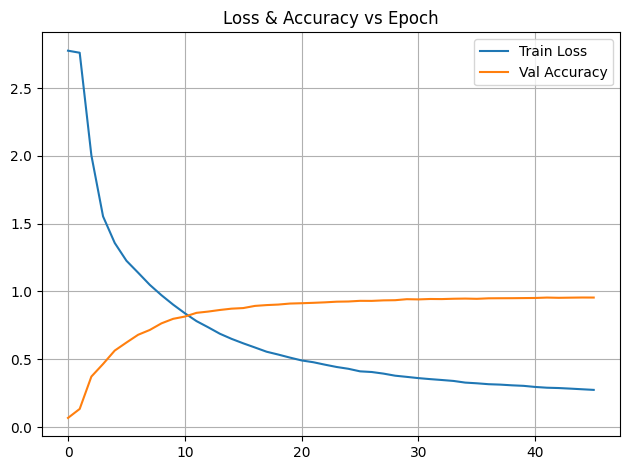

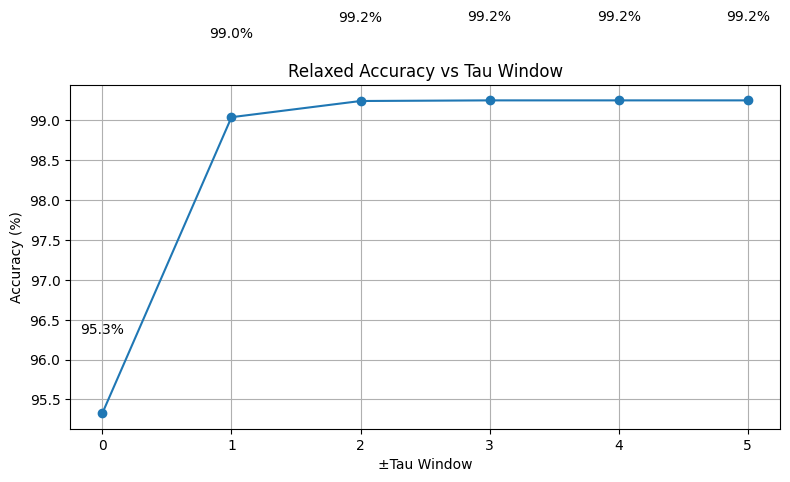

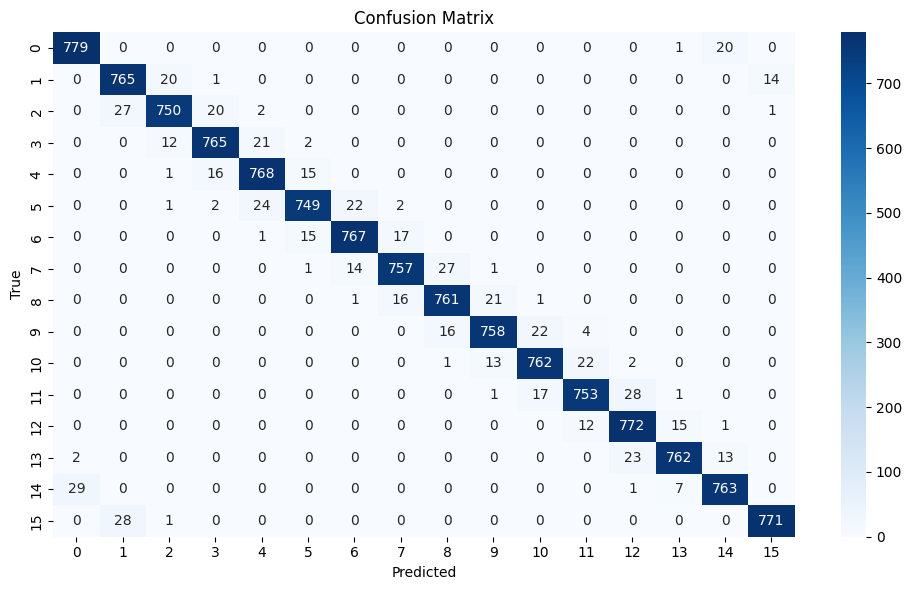


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T15_n15_seed0_bsc_p0.01_codewords1_state.pth
  full model -> /kaggle/working/cpd_T15_n15_seed0_bsc_p0.01_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T15_n15_seed0_bsc_p0.01_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T15_n15_seed0_bsc_p0.01_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T15_n15_seed0_bsc_p0.01_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [3]:
# ========================= Full, Download-Ready Trainer =========================
# Adds: saving state/full/TorchScript/meta to /kaggle/working + a ZIP bundle
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 15
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 8000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.01_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # init robustly
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create an informative filename prefix (includes dataset tag)
ds_tag = f"{os.path.splitext(os.path.basename(csv1_path))[0]}"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Save state_dict (recommended portable format)
torch.save(best_model_state, STATE_PATH)

# 2) Save full pickled model (convenient but environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Save metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything into a ZIP to download in one click
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================



## T = 20, p = 0.05

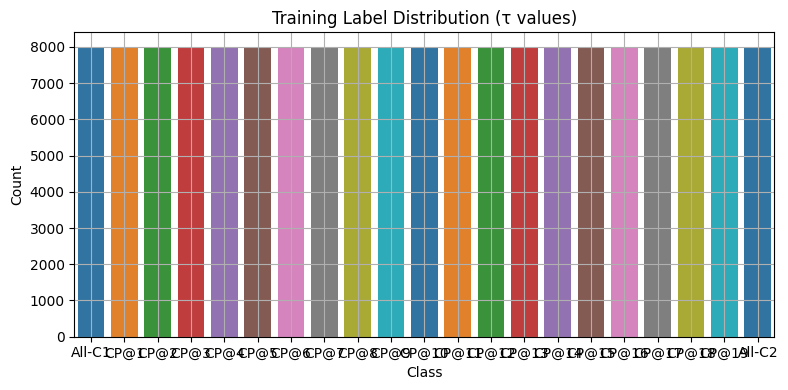

Training Epochs:   2%|▏         | 1/50 [00:27<22:40, 27.76s/it]

Epoch  1 | Train Loss: 3.0470 | Val Accuracy: 0.0489


Training Epochs:   4%|▍         | 2/50 [00:53<21:27, 26.82s/it]

Epoch  2 | Train Loss: 3.0408 | Val Accuracy: 0.0817


Training Epochs:   6%|▌         | 3/50 [01:16<19:24, 24.78s/it]

Epoch  3 | Train Loss: 2.3566 | Val Accuracy: 0.2930


Training Epochs:   8%|▊         | 4/50 [01:39<18:32, 24.19s/it]

Epoch  4 | Train Loss: 1.8794 | Val Accuracy: 0.4048


Training Epochs:  10%|█         | 5/50 [02:02<17:52, 23.83s/it]

Epoch  5 | Train Loss: 1.6717 | Val Accuracy: 0.4704


Training Epochs:  12%|█▏        | 6/50 [02:25<17:08, 23.38s/it]

Epoch  6 | Train Loss: 1.5443 | Val Accuracy: 0.5279


Training Epochs:  14%|█▍        | 7/50 [02:47<16:23, 22.87s/it]

Epoch  7 | Train Loss: 1.4518 | Val Accuracy: 0.5552


Training Epochs:  16%|█▌        | 8/50 [03:08<15:46, 22.54s/it]

Epoch  8 | Train Loss: 1.3736 | Val Accuracy: 0.6064


Training Epochs:  18%|█▊        | 9/50 [03:30<15:13, 22.29s/it]

Epoch  9 | Train Loss: 1.3085 | Val Accuracy: 0.6177


Training Epochs:  20%|██        | 10/50 [03:52<14:45, 22.14s/it]

Epoch 10 | Train Loss: 1.2514 | Val Accuracy: 0.6528


Training Epochs:  22%|██▏       | 11/50 [04:14<14:19, 22.05s/it]

Epoch 11 | Train Loss: 1.2017 | Val Accuracy: 0.6789


Training Epochs:  24%|██▍       | 12/50 [04:36<13:56, 22.01s/it]

Epoch 12 | Train Loss: 1.1612 | Val Accuracy: 0.6958


Training Epochs:  26%|██▌       | 13/50 [04:58<13:32, 21.96s/it]

Epoch 13 | Train Loss: 1.1224 | Val Accuracy: 0.7090


Training Epochs:  28%|██▊       | 14/50 [05:20<13:10, 21.96s/it]

Epoch 14 | Train Loss: 1.0864 | Val Accuracy: 0.7245


Training Epochs:  30%|███       | 15/50 [05:42<12:53, 22.10s/it]

Epoch 15 | Train Loss: 1.0552 | Val Accuracy: 0.7335


Training Epochs:  32%|███▏      | 16/50 [06:04<12:33, 22.16s/it]

Epoch 16 | Train Loss: 1.0279 | Val Accuracy: 0.7429


Training Epochs:  34%|███▍      | 17/50 [06:26<12:09, 22.11s/it]

Epoch 17 | Train Loss: 0.9990 | Val Accuracy: 0.7431


Training Epochs:  36%|███▌      | 18/50 [06:48<11:46, 22.09s/it]

Epoch 18 | Train Loss: 0.9785 | Val Accuracy: 0.7523


Training Epochs:  38%|███▊      | 19/50 [07:10<11:23, 22.06s/it]

Epoch 19 | Train Loss: 0.9542 | Val Accuracy: 0.7583


Training Epochs:  40%|████      | 20/50 [07:32<11:01, 22.06s/it]

Epoch 20 | Train Loss: 0.9348 | Val Accuracy: 0.7588


Training Epochs:  42%|████▏     | 21/50 [07:54<10:39, 22.05s/it]

Epoch 21 | Train Loss: 0.9199 | Val Accuracy: 0.7626


Training Epochs:  44%|████▍     | 22/50 [08:16<10:17, 22.05s/it]

Epoch 22 | Train Loss: 0.9074 | Val Accuracy: 0.7662


Training Epochs:  46%|████▌     | 23/50 [08:39<09:55, 22.06s/it]

Epoch 23 | Train Loss: 0.8898 | Val Accuracy: 0.7661


Training Epochs:  48%|████▊     | 24/50 [09:01<09:33, 22.06s/it]

Epoch 24 | Train Loss: 0.8782 | Val Accuracy: 0.7701


Training Epochs:  50%|█████     | 25/50 [09:23<09:11, 22.06s/it]

Epoch 25 | Train Loss: 0.8656 | Val Accuracy: 0.7706


Training Epochs:  52%|█████▏    | 26/50 [09:45<08:49, 22.07s/it]

Epoch 26 | Train Loss: 0.8567 | Val Accuracy: 0.7714


Training Epochs:  54%|█████▍    | 27/50 [10:07<08:28, 22.10s/it]

Epoch 27 | Train Loss: 0.8475 | Val Accuracy: 0.7785


Training Epochs:  56%|█████▌    | 28/50 [10:29<08:05, 22.09s/it]

Epoch 28 | Train Loss: 0.8355 | Val Accuracy: 0.7759


Training Epochs:  58%|█████▊    | 29/50 [10:51<07:43, 22.07s/it]

Epoch 29 | Train Loss: 0.8276 | Val Accuracy: 0.7773


Training Epochs:  60%|██████    | 30/50 [11:13<07:20, 22.03s/it]

Epoch 30 | Train Loss: 0.8190 | Val Accuracy: 0.7837


Training Epochs:  62%|██████▏   | 31/50 [11:35<06:57, 21.99s/it]

Epoch 31 | Train Loss: 0.8057 | Val Accuracy: 0.7779


Training Epochs:  64%|██████▍   | 32/50 [11:57<06:35, 21.96s/it]

Epoch 32 | Train Loss: 0.8010 | Val Accuracy: 0.7833


Training Epochs:  66%|██████▌   | 33/50 [12:19<06:14, 22.02s/it]

Epoch 33 | Train Loss: 0.7942 | Val Accuracy: 0.7788


Training Epochs:  66%|██████▌   | 33/50 [12:41<06:32, 23.07s/it]

Epoch 34 | Train Loss: 0.7827 | Val Accuracy: 0.7831
Early stopping triggered.



Final Test Accuracy: 0.7810



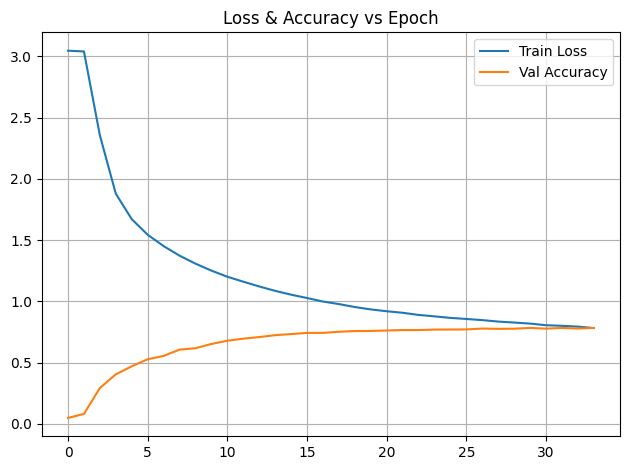

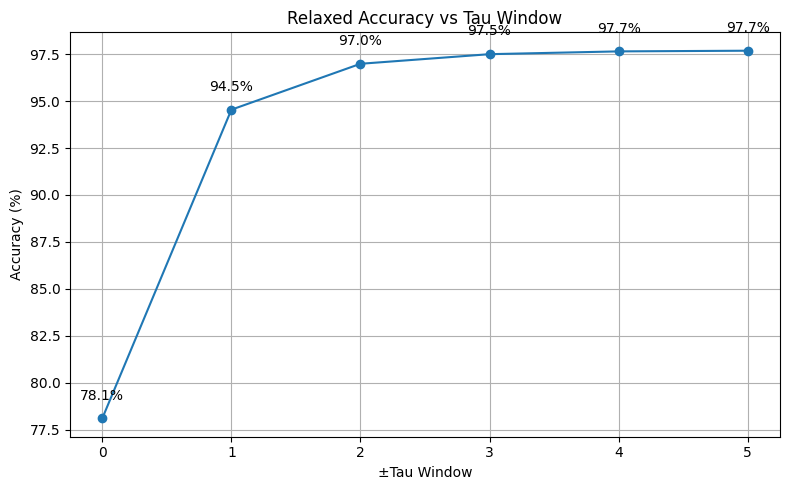

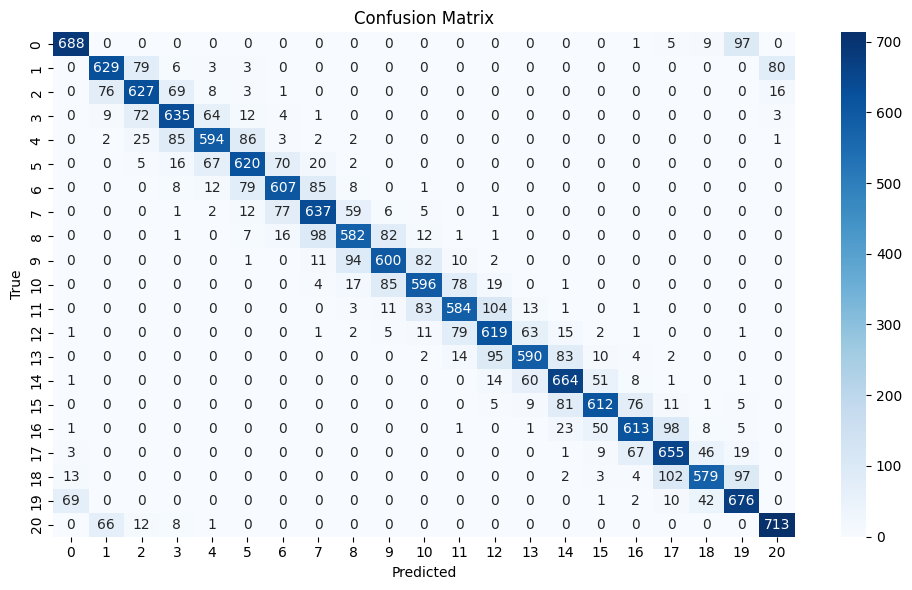


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.05_codewords1_state.pth
  full model -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.05_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.05_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.05_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.05_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [4]:
# ========================= Full, Download-Ready Trainer =========================
# Adds: saving state/full/TorchScript/meta to /kaggle/working + a ZIP bundle
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 20
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 8000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # init robustly
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create an informative filename prefix (includes dataset tag)
ds_tag = f"{os.path.splitext(os.path.basename(csv1_path))[0]}"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Save state_dict (recommended portable format)
torch.save(best_model_state, STATE_PATH)

# 2) Save full pickled model (convenient but environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Save metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything into a ZIP to download in one click
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================



## T = 25, p = 0.05

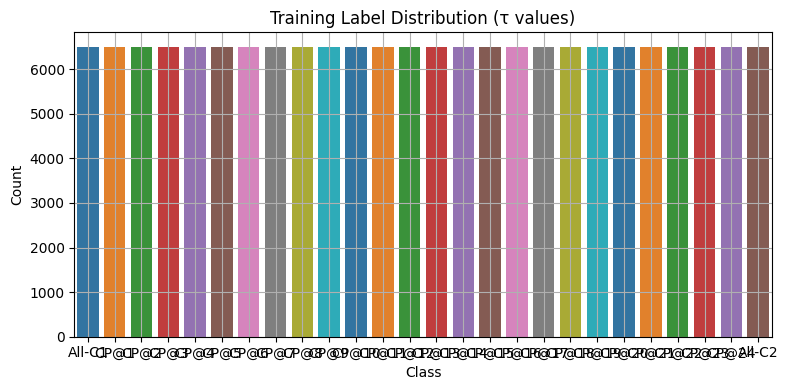

Training Epochs:   2%|▏         | 1/50 [00:22<18:12, 22.30s/it]

Epoch  1 | Train Loss: 3.2605 | Val Accuracy: 0.0414


Training Epochs:   4%|▍         | 2/50 [00:44<17:43, 22.16s/it]

Epoch  2 | Train Loss: 3.2330 | Val Accuracy: 0.0883


Training Epochs:   6%|▌         | 3/50 [01:06<17:20, 22.14s/it]

Epoch  3 | Train Loss: 2.4171 | Val Accuracy: 0.2934


Training Epochs:   8%|▊         | 4/50 [01:28<16:55, 22.08s/it]

Epoch  4 | Train Loss: 1.9572 | Val Accuracy: 0.4006


Training Epochs:  10%|█         | 5/50 [01:50<16:31, 22.03s/it]

Epoch  5 | Train Loss: 1.7495 | Val Accuracy: 0.4579


Training Epochs:  12%|█▏        | 6/50 [02:12<16:11, 22.09s/it]

Epoch  6 | Train Loss: 1.6160 | Val Accuracy: 0.5189


Training Epochs:  14%|█▍        | 7/50 [02:34<15:51, 22.12s/it]

Epoch  7 | Train Loss: 1.5103 | Val Accuracy: 0.5704


Training Epochs:  16%|█▌        | 8/50 [02:57<15:30, 22.15s/it]

Epoch  8 | Train Loss: 1.4270 | Val Accuracy: 0.5850


Training Epochs:  18%|█▊        | 9/50 [03:19<15:09, 22.18s/it]

Epoch  9 | Train Loss: 1.3633 | Val Accuracy: 0.6373


Training Epochs:  20%|██        | 10/50 [03:41<14:46, 22.17s/it]

Epoch 10 | Train Loss: 1.3065 | Val Accuracy: 0.6630


Training Epochs:  22%|██▏       | 11/50 [04:03<14:24, 22.16s/it]

Epoch 11 | Train Loss: 1.2588 | Val Accuracy: 0.6796


Training Epochs:  24%|██▍       | 12/50 [04:25<14:01, 22.15s/it]

Epoch 12 | Train Loss: 1.2167 | Val Accuracy: 0.6976


Training Epochs:  26%|██▌       | 13/50 [04:47<13:38, 22.12s/it]

Epoch 13 | Train Loss: 1.1792 | Val Accuracy: 0.7108


Training Epochs:  28%|██▊       | 14/50 [05:09<13:17, 22.14s/it]

Epoch 14 | Train Loss: 1.1433 | Val Accuracy: 0.7282


Training Epochs:  30%|███       | 15/50 [05:32<12:55, 22.17s/it]

Epoch 15 | Train Loss: 1.1100 | Val Accuracy: 0.7419


Training Epochs:  32%|███▏      | 16/50 [05:53<12:30, 22.07s/it]

Epoch 16 | Train Loss: 1.0849 | Val Accuracy: 0.7501


Training Epochs:  34%|███▍      | 17/50 [06:15<12:06, 22.02s/it]

Epoch 17 | Train Loss: 1.0542 | Val Accuracy: 0.7570


Training Epochs:  36%|███▌      | 18/50 [06:37<11:43, 21.99s/it]

Epoch 18 | Train Loss: 1.0324 | Val Accuracy: 0.7623


Training Epochs:  38%|███▊      | 19/50 [07:00<11:23, 22.06s/it]

Epoch 19 | Train Loss: 1.0115 | Val Accuracy: 0.7646


Training Epochs:  40%|████      | 20/50 [07:22<11:04, 22.13s/it]

Epoch 20 | Train Loss: 0.9885 | Val Accuracy: 0.7696


Training Epochs:  42%|████▏     | 21/50 [07:44<10:41, 22.13s/it]

Epoch 21 | Train Loss: 0.9766 | Val Accuracy: 0.7715


Training Epochs:  44%|████▍     | 22/50 [08:06<10:18, 22.09s/it]

Epoch 22 | Train Loss: 0.9587 | Val Accuracy: 0.7724


Training Epochs:  46%|████▌     | 23/50 [08:28<09:55, 22.04s/it]

Epoch 23 | Train Loss: 0.9473 | Val Accuracy: 0.7721


Training Epochs:  48%|████▊     | 24/50 [08:50<09:32, 22.02s/it]

Epoch 24 | Train Loss: 0.9298 | Val Accuracy: 0.7797


Training Epochs:  50%|█████     | 25/50 [09:12<09:10, 22.02s/it]

Epoch 25 | Train Loss: 0.9187 | Val Accuracy: 0.7844


Training Epochs:  52%|█████▏    | 26/50 [09:34<08:50, 22.10s/it]

Epoch 26 | Train Loss: 0.9086 | Val Accuracy: 0.7843


Training Epochs:  54%|█████▍    | 27/50 [09:56<08:28, 22.12s/it]

Epoch 27 | Train Loss: 0.8972 | Val Accuracy: 0.7860


Training Epochs:  56%|█████▌    | 28/50 [10:18<08:06, 22.09s/it]

Epoch 28 | Train Loss: 0.8870 | Val Accuracy: 0.7868


Training Epochs:  58%|█████▊    | 29/50 [10:40<07:43, 22.07s/it]

Epoch 29 | Train Loss: 0.8759 | Val Accuracy: 0.7868


Training Epochs:  60%|██████    | 30/50 [11:02<07:20, 22.04s/it]

Epoch 30 | Train Loss: 0.8669 | Val Accuracy: 0.7924


Training Epochs:  62%|██████▏   | 31/50 [11:24<06:58, 22.00s/it]

Epoch 31 | Train Loss: 0.8606 | Val Accuracy: 0.7901


Training Epochs:  64%|██████▍   | 32/50 [11:46<06:36, 22.02s/it]

Epoch 32 | Train Loss: 0.8502 | Val Accuracy: 0.7925


Training Epochs:  66%|██████▌   | 33/50 [12:08<06:14, 22.06s/it]

Epoch 33 | Train Loss: 0.8406 | Val Accuracy: 0.7937


Training Epochs:  68%|██████▊   | 34/50 [12:30<05:52, 22.05s/it]

Epoch 34 | Train Loss: 0.8361 | Val Accuracy: 0.7959


Training Epochs:  70%|███████   | 35/50 [12:53<05:30, 22.05s/it]

Epoch 35 | Train Loss: 0.8298 | Val Accuracy: 0.7962


Training Epochs:  72%|███████▏  | 36/50 [13:15<05:08, 22.03s/it]

Epoch 36 | Train Loss: 0.8175 | Val Accuracy: 0.8010


Training Epochs:  74%|███████▍  | 37/50 [13:37<04:46, 22.04s/it]

Epoch 37 | Train Loss: 0.8128 | Val Accuracy: 0.7995


Training Epochs:  76%|███████▌  | 38/50 [13:59<04:24, 22.05s/it]

Epoch 38 | Train Loss: 0.8087 | Val Accuracy: 0.7980


Training Epochs:  78%|███████▊  | 39/50 [14:21<04:02, 22.06s/it]

Epoch 39 | Train Loss: 0.8003 | Val Accuracy: 0.7993


Training Epochs:  78%|███████▊  | 39/50 [14:43<04:09, 22.65s/it]

Epoch 40 | Train Loss: 0.7989 | Val Accuracy: 0.8022
Early stopping triggered.



Final Test Accuracy: 0.7994



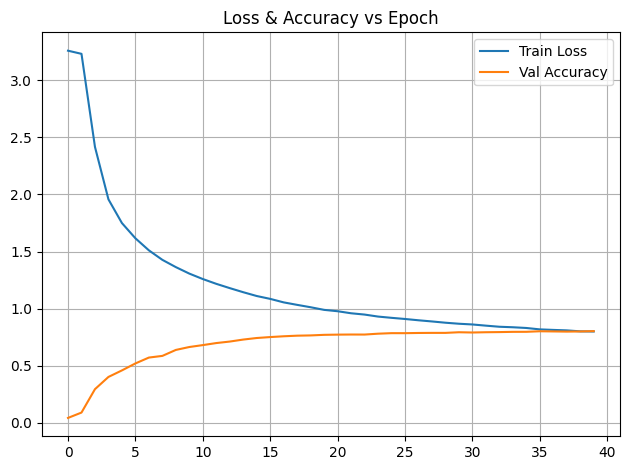

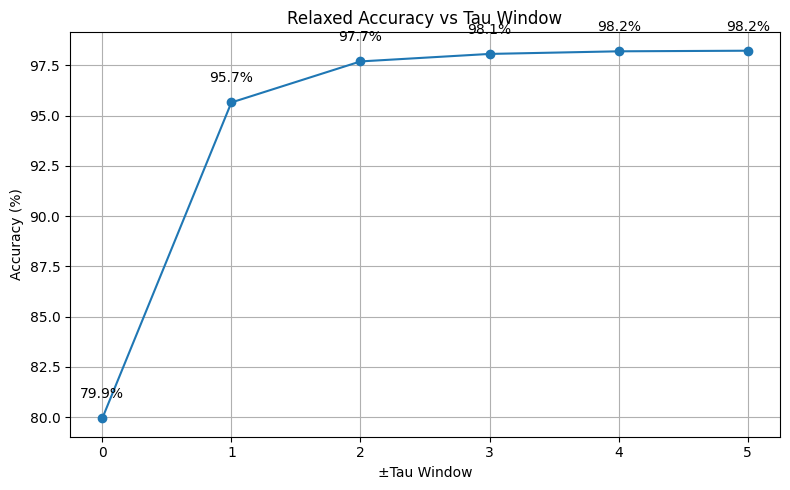

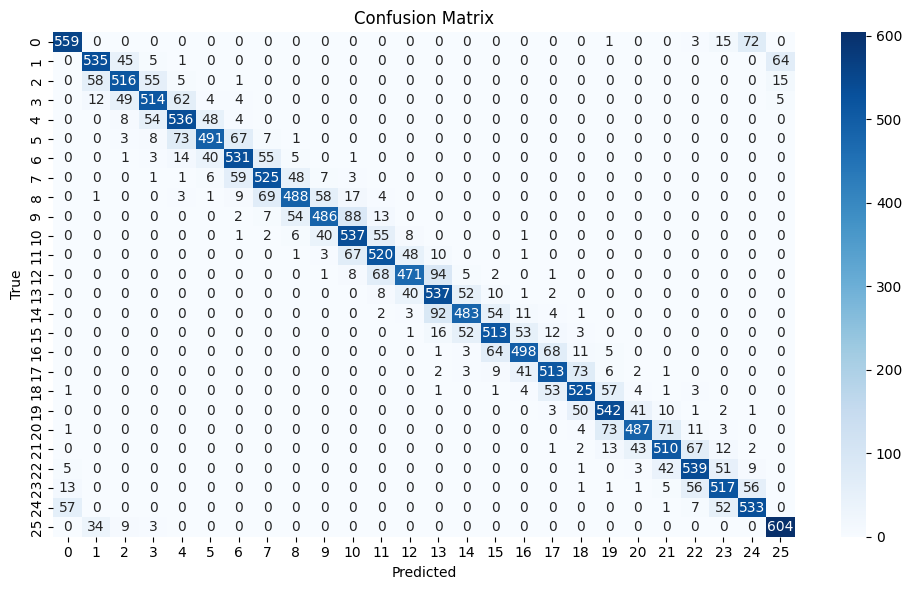


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T25_n15_seed0_bsc_p0.05_codewords1_state.pth
  full model -> /kaggle/working/cpd_T25_n15_seed0_bsc_p0.05_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T25_n15_seed0_bsc_p0.05_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T25_n15_seed0_bsc_p0.05_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T25_n15_seed0_bsc_p0.05_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [6]:
# ========================= Full, Download-Ready Trainer =========================
# Adds: saving state/full/TorchScript/meta to /kaggle/working + a ZIP bundle
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 25
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 6500
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.05_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # init robustly
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create an informative filename prefix (includes dataset tag)
ds_tag = f"{os.path.splitext(os.path.basename(csv1_path))[0]}"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Save state_dict (recommended portable format)
torch.save(best_model_state, STATE_PATH)

# 2) Save full pickled model (convenient but environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Save metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything into a ZIP to download in one click
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================



## T = 25, p = 0.10

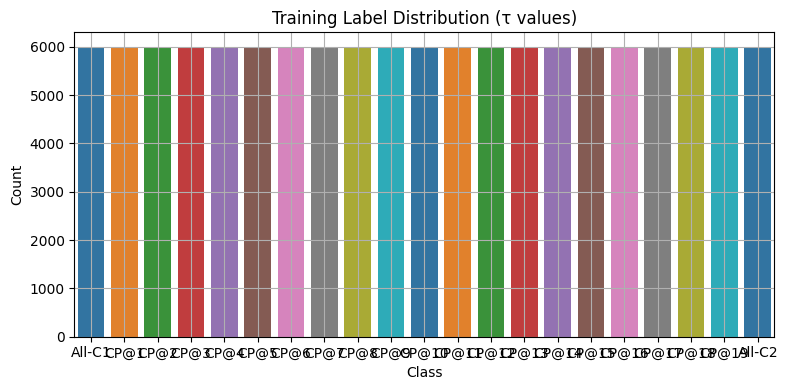

Training Epochs:   2%|▏         | 1/50 [00:16<13:21, 16.36s/it]

Epoch  1 | Train Loss: 3.0476 | Val Accuracy: 0.0479


Training Epochs:   4%|▍         | 2/50 [00:32<13:06, 16.39s/it]

Epoch  2 | Train Loss: 3.0449 | Val Accuracy: 0.0478


Training Epochs:   6%|▌         | 3/50 [00:49<12:48, 16.35s/it]

Epoch  3 | Train Loss: 3.0442 | Val Accuracy: 0.0521


Training Epochs:   8%|▊         | 4/50 [01:05<12:33, 16.38s/it]

Epoch  4 | Train Loss: 3.0261 | Val Accuracy: 0.0878


Training Epochs:  10%|█         | 5/50 [01:21<12:15, 16.35s/it]

Epoch  5 | Train Loss: 2.6520 | Val Accuracy: 0.1735


Training Epochs:  12%|█▏        | 6/50 [01:38<11:59, 16.36s/it]

Epoch  6 | Train Loss: 2.3172 | Val Accuracy: 0.2356


Training Epochs:  14%|█▍        | 7/50 [01:54<11:44, 16.39s/it]

Epoch  7 | Train Loss: 2.1475 | Val Accuracy: 0.2668


Training Epochs:  16%|█▌        | 8/50 [02:11<11:29, 16.41s/it]

Epoch  8 | Train Loss: 2.0501 | Val Accuracy: 0.2867


Training Epochs:  18%|█▊        | 9/50 [02:27<11:13, 16.42s/it]

Epoch  9 | Train Loss: 1.9754 | Val Accuracy: 0.3112


Training Epochs:  20%|██        | 10/50 [02:43<10:57, 16.43s/it]

Epoch 10 | Train Loss: 1.9207 | Val Accuracy: 0.3332


Training Epochs:  22%|██▏       | 11/50 [03:00<10:40, 16.42s/it]

Epoch 11 | Train Loss: 1.8738 | Val Accuracy: 0.3357


Training Epochs:  24%|██▍       | 12/50 [03:16<10:23, 16.41s/it]

Epoch 12 | Train Loss: 1.8259 | Val Accuracy: 0.3542


Training Epochs:  26%|██▌       | 13/50 [03:33<10:06, 16.38s/it]

Epoch 13 | Train Loss: 1.7930 | Val Accuracy: 0.3661


Training Epochs:  28%|██▊       | 14/50 [03:49<09:49, 16.38s/it]

Epoch 14 | Train Loss: 1.7579 | Val Accuracy: 0.3756


Training Epochs:  30%|███       | 15/50 [04:05<09:33, 16.39s/it]

Epoch 15 | Train Loss: 1.7269 | Val Accuracy: 0.3946


Training Epochs:  32%|███▏      | 16/50 [04:22<09:19, 16.46s/it]

Epoch 16 | Train Loss: 1.7009 | Val Accuracy: 0.4008


Training Epochs:  34%|███▍      | 17/50 [04:38<09:03, 16.47s/it]

Epoch 17 | Train Loss: 1.6748 | Val Accuracy: 0.4115


Training Epochs:  36%|███▌      | 18/50 [04:55<08:46, 16.46s/it]

Epoch 18 | Train Loss: 1.6533 | Val Accuracy: 0.4221


Training Epochs:  38%|███▊      | 19/50 [05:11<08:30, 16.46s/it]

Epoch 19 | Train Loss: 1.6314 | Val Accuracy: 0.4223


Training Epochs:  40%|████      | 20/50 [05:28<08:11, 16.40s/it]

Epoch 20 | Train Loss: 1.6134 | Val Accuracy: 0.4311


Training Epochs:  42%|████▏     | 21/50 [05:44<07:55, 16.39s/it]

Epoch 21 | Train Loss: 1.5973 | Val Accuracy: 0.4272


Training Epochs:  44%|████▍     | 22/50 [06:00<07:38, 16.37s/it]

Epoch 22 | Train Loss: 1.5802 | Val Accuracy: 0.4443


Training Epochs:  46%|████▌     | 23/50 [06:17<07:21, 16.37s/it]

Epoch 23 | Train Loss: 1.5624 | Val Accuracy: 0.4488


Training Epochs:  48%|████▊     | 24/50 [06:33<07:05, 16.37s/it]

Epoch 24 | Train Loss: 1.5510 | Val Accuracy: 0.4503


Training Epochs:  50%|█████     | 25/50 [06:49<06:49, 16.38s/it]

Epoch 25 | Train Loss: 1.5359 | Val Accuracy: 0.4526


Training Epochs:  52%|█████▏    | 26/50 [07:06<06:34, 16.43s/it]

Epoch 26 | Train Loss: 1.5238 | Val Accuracy: 0.4634


Training Epochs:  54%|█████▍    | 27/50 [07:22<06:17, 16.42s/it]

Epoch 27 | Train Loss: 1.5096 | Val Accuracy: 0.4649


Training Epochs:  56%|█████▌    | 28/50 [07:39<06:00, 16.39s/it]

Epoch 28 | Train Loss: 1.4969 | Val Accuracy: 0.4715


Training Epochs:  58%|█████▊    | 29/50 [07:55<05:44, 16.40s/it]

Epoch 29 | Train Loss: 1.4863 | Val Accuracy: 0.4687


Training Epochs:  60%|██████    | 30/50 [08:11<05:27, 16.36s/it]

Epoch 30 | Train Loss: 1.4745 | Val Accuracy: 0.4764


Training Epochs:  62%|██████▏   | 31/50 [08:28<05:10, 16.33s/it]

Epoch 31 | Train Loss: 1.4636 | Val Accuracy: 0.4851


Training Epochs:  64%|██████▍   | 32/50 [08:44<04:54, 16.34s/it]

Epoch 32 | Train Loss: 1.4564 | Val Accuracy: 0.4821


Training Epochs:  66%|██████▌   | 33/50 [09:00<04:37, 16.34s/it]

Epoch 33 | Train Loss: 1.4468 | Val Accuracy: 0.4825


Training Epochs:  68%|██████▊   | 34/50 [09:17<04:21, 16.37s/it]

Epoch 34 | Train Loss: 1.4365 | Val Accuracy: 0.4955


Training Epochs:  70%|███████   | 35/50 [09:33<04:06, 16.41s/it]

Epoch 35 | Train Loss: 1.4261 | Val Accuracy: 0.4977


Training Epochs:  72%|███████▏  | 36/50 [09:50<03:49, 16.39s/it]

Epoch 36 | Train Loss: 1.4170 | Val Accuracy: 0.4952


Training Epochs:  74%|███████▍  | 37/50 [10:06<03:32, 16.36s/it]

Epoch 37 | Train Loss: 1.4098 | Val Accuracy: 0.4945


Training Epochs:  76%|███████▌  | 38/50 [10:22<03:16, 16.35s/it]

Epoch 38 | Train Loss: 1.4005 | Val Accuracy: 0.5032


Training Epochs:  78%|███████▊  | 39/50 [10:39<02:59, 16.36s/it]

Epoch 39 | Train Loss: 1.3972 | Val Accuracy: 0.5063


Training Epochs:  80%|████████  | 40/50 [10:55<02:43, 16.35s/it]

Epoch 40 | Train Loss: 1.3860 | Val Accuracy: 0.5050


Training Epochs:  82%|████████▏ | 41/50 [11:11<02:27, 16.36s/it]

Epoch 41 | Train Loss: 1.3813 | Val Accuracy: 0.5056


Training Epochs:  84%|████████▍ | 42/50 [11:28<02:10, 16.34s/it]

Epoch 42 | Train Loss: 1.3745 | Val Accuracy: 0.5088


Training Epochs:  86%|████████▌ | 43/50 [11:44<01:54, 16.37s/it]

Epoch 43 | Train Loss: 1.3686 | Val Accuracy: 0.5130


Training Epochs:  88%|████████▊ | 44/50 [12:01<01:38, 16.39s/it]

Epoch 44 | Train Loss: 1.3608 | Val Accuracy: 0.5096


Training Epochs:  90%|█████████ | 45/50 [12:17<01:21, 16.38s/it]

Epoch 45 | Train Loss: 1.3556 | Val Accuracy: 0.5102


Training Epochs:  92%|█████████▏| 46/50 [12:33<01:05, 16.39s/it]

Epoch 46 | Train Loss: 1.3472 | Val Accuracy: 0.5116


Training Epochs:  92%|█████████▏| 46/50 [12:50<01:06, 16.74s/it]

Epoch 47 | Train Loss: 1.3462 | Val Accuracy: 0.5116
Early stopping triggered.



Final Test Accuracy: 0.5222



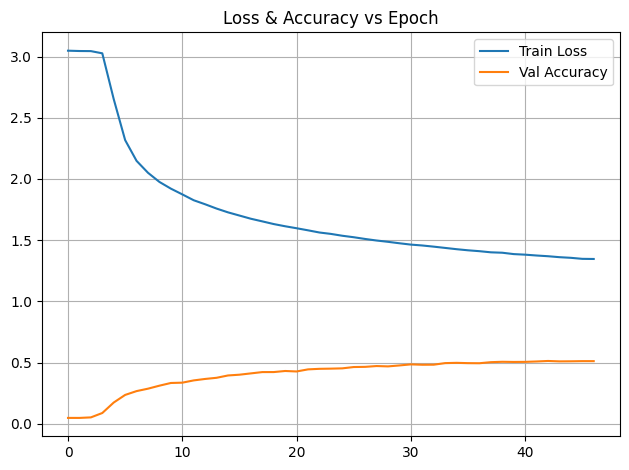

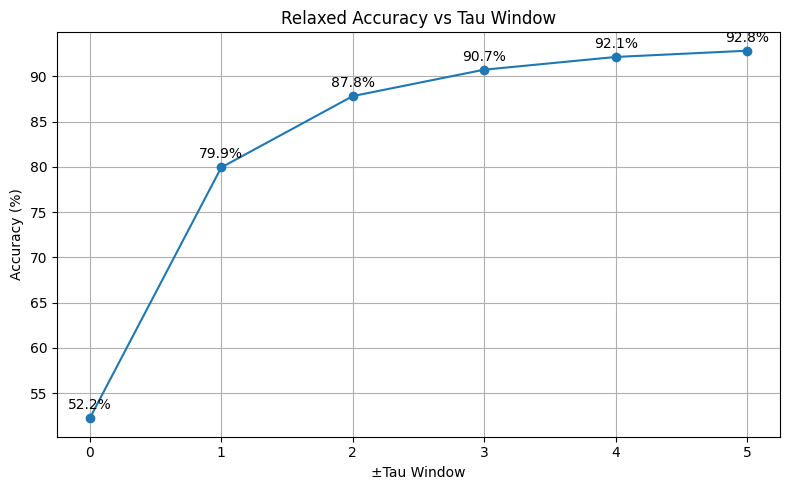

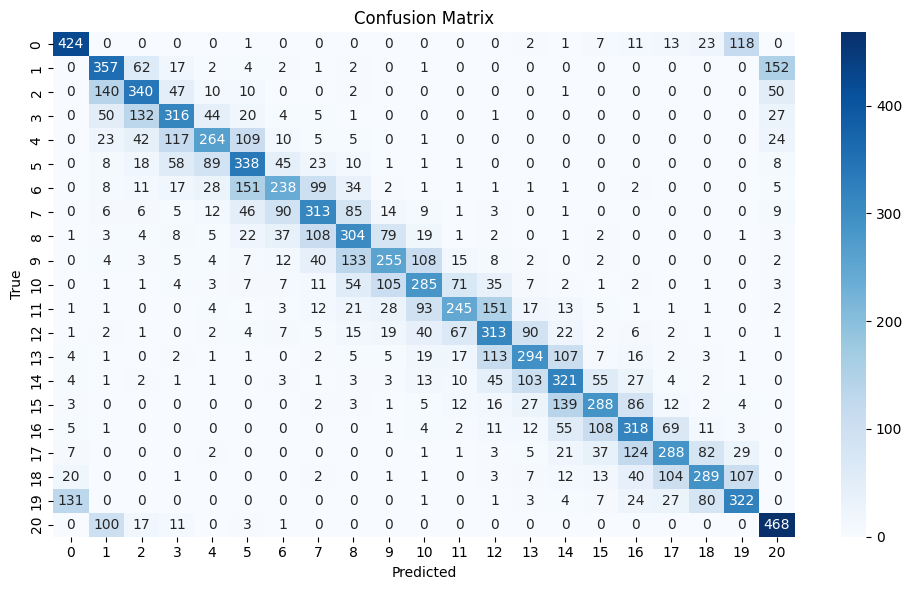


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.10_codewords1_state.pth
  full model -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.10_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.10_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.10_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T20_n15_seed0_bsc_p0.10_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


In [5]:
# ========================= Full, Download-Ready Trainer =========================
# Adds: saving state/full/TorchScript/meta to /kaggle/working + a ZIP bundle
# ==============================================================================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 20
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 6000
SAMPLES_PER_CLASS_TEST = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords1.csv"
csv2_path = "/kaggle/input/bsc-0-01-15-seq-len/bsc_p0.10_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val, y_val     = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test, y_test   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)  # -> 96 channels
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, T, n) -> (B, n, T)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x) # (B, C, 1)
        return self.classifier(x)   # (B, num_classes)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())  # init robustly
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc  = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ==================== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ====================
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create an informative filename prefix (includes dataset tag)
ds_tag = f"{os.path.splitext(os.path.basename(csv1_path))[0]}"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")
TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Save state_dict (recommended portable format)
torch.save(best_model_state, STATE_PATH)

# 2) Save full pickled model (convenient but environment-dependent)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (script -> trace fallback)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Save metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything into a ZIP to download in one click
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")
# ==============================================================================

